In [2]:
import numpy as np
from scipy.sparse.linalg import eigsh
from scipy.sparse import csr_matrix, kron
import os
import matplotlib.pyplot as plt
from quant_rotor.core.hamiltonian import hamiltonian
from quant_rotor.core.hamiltonian_big import hamiltonian_general, hamiltonian_big
from quant_rotor.core.t_amplitudes_periodic import t_periodic
from quant_rotor.models.density_matrix import density_matrix_1
from quant_rotor.models.t_amplitudes_guess import intermediate_normalisation, t_1_amplitude_guess_ground_state, t_2_amplitude_guess_ground_state, amplitute_energy, t_2_amplitutde

# functions

In [3]:
def load_one_simulation_NO(sites: int, states: int, g: float, directory: str = ".") -> dict:
    """
    Loads eigenvalues, eigenvectors, and NO basis matrix for a specific (sites, states, g) system.

    Returns a dictionary with 'eigvals', 'eigvecs', and 'NO_basis'.
    """
    g_str = f"{g:.1f}"
    base = f"sites{sites}_states{states}_g{g_str}"

    eigvals_path = os.path.join(directory, f"NO_eigvals_{base}.npy")
    eigvecs_path = os.path.join(directory, f"NO_eigvecs_{base}.npy")
    NO_basis_path = os.path.join(directory, f"NO_basis_{base}.npy")

    try:
        eigvals = np.load(eigvals_path)
        eigvecs = np.load(eigvecs_path)
        NO_basis = np.load(NO_basis_path)

        return eigvals, eigvecs, NO_basis

    except FileNotFoundError as e:
        print(f"[Error] Missing file for (sites={sites}, states={states}, g={g_str}): {e}")
        return {}

In [4]:
def load_one_simulation_ED(sites: int, states: int, g: float, directory: str = ".") -> dict:
    """
    Loads eigenvalues, eigenvectors, and NO basis matrix for a specific (sites, states, g) system.

    Returns a dictionary with 'eigvals', 'eigvecs', and 'NO_basis'.
    """
    g_str = f"{g:.1f}"
    base = f"sites{sites}_states{states}_g{g_str}"

    eigvals_path = os.path.join(directory, f"eigvals_{base}.npy")
    eigvecs_path = os.path.join(directory, f"eigvecs_{base}.npy")

    try:
        eigvals = np.load(eigvals_path)
        eigvecs = np.load(eigvecs_path)

        return eigvals, eigvecs

    except FileNotFoundError as e:
        print(f"[Error] Missing file for (sites={sites}, states={states}, g={g_str}): {e}")
        return None

In [5]:
def load_one_simulation_t_amplitudes(sites: int, states: int, g: float, directory: str = ".") -> dict:
    """
    Loads eigenvalues, eigenvectors, and NO basis matrix for a specific (sites, states, g) system.

    Returns a dictionary with 'eigvals', 'eigvecs', and 'NO_basis'.
    """
    g_str = f"{g:.2f}"
    base = f"sites{sites}_states{states}_g{g_str}"

    t_1_path = os.path.join(directory, f"t_1{base}.npy")
    t_2_path = os.path.join(directory, f"t_2{base}.npy")

    try:
        t_1 = np.load(t_1_path)
        t_2 = np.load(t_2_path)

        return t_1, t_2

    except FileNotFoundError as e:
        print(f"[Error] Missing file for (sites={sites}, states={states}, g={g_str}): {e}")
        return {}

In [6]:
def load_one_simulation_t_amplitudes_t_2(sites: int, states: int, g: float, directory: str = ".") -> dict:
    """
    Loads eigenvalues, eigenvectors, and NO basis matrix for a specific (sites, states, g) system.

    Returns a dictionary with 'eigvals', 'eigvecs', and 'NO_basis'.
    """
    g_str = f"{g:.2f}"
    base = f"sites{sites}_states{states}_g{g_str}"

    t_2_path = os.path.join(directory, f"t_2{base}.npy")

    try:
        t_2 = np.load(t_2_path)

        return t_2

    except FileNotFoundError as e:
        print(f"[Error] Missing file for (sites={sites}, states={states}, g={g_str}): {e}")
        return {}

In [7]:
def scatter_and_fit(g, y, label, color, degree=10, visible_indices=None):
    """
    Plot selected points from (g, y), fit to full data, and draw the fit curve.

    Parameters:
        g, y: full data arrays
        label: label for legend
        color: color for plot
        degree: degree of polynomial fit
        visible_indices: indices of points to show in the scatter plot
    """
    g = np.asarray(g)
    y = np.asarray(y)

    if visible_indices is not None:
        g_visible = g[visible_indices]
        y_visible = y[visible_indices]
    else:
        g_visible = g
        y_visible = y

    # Show only selected data points
    plt.scatter(g_visible, y_visible, label=f"{label}", color=color, s=30)

    # Fit to full data
    coeffs = np.polyfit(g, y, degree)
    poly_fn = np.poly1d(coeffs)

    # Plot fitted polynomial
    g_smooth = np.linspace(g.min(), g.max(), 300)
    y_smooth = poly_fn(g_smooth)
    plt.plot(g_smooth, y_smooth, linestyle='--', color=color)

In [8]:
def fit_and_display_slope_in_range(g, y, g_min, g_max, label="Slope Fit", color="black", degree=1):
    """
    Fit and display a polynomial in a subrange of (g, y), and print and annotate the slope or derivative.

    Parameters:
        g, y: full data arrays
        g_min, g_max: range to subset
        label: label for the fit line
        color: line color
        degree: degree of polynomial (1 = linear)
    """
    g = np.asarray(g)
    y = np.asarray(y)

    # Select the range
    mask = (g >= g_min) & (g <= g_max)
    g_range = g[mask]
    y_range = y[mask]

    if len(g_range) < degree + 1:
        print(f"Not enough points to fit degree {degree} polynomial in range ({g_min}, {g_max})")
        return

    # Fit polynomial
    coeffs = np.polyfit(g_range, y_range, degree)
    poly_fn = np.poly1d(coeffs)

    # Plot the fit over the range
    g_fit = np.linspace(g_min, g_max, 200)
    y_fit = poly_fn(g_fit)
    plt.plot(g_fit, y_fit, color=color, linestyle='-', label=f"{label}")

    # Compute and annotate slope at midpoint
    poly_deriv = poly_fn.deriv()
    g_mid = (g_min + g_max) / 2
    slope_at_mid = poly_deriv(g_mid)

    # Print in console
    print(f"{label} – dE/dg at g ≈ {g_mid:.3f} is {slope_at_mid:.6f}")

    # Annotate on plot
    y_mid = poly_fn(g_mid)
    plt.text(g_mid - 0.3, y_mid + 0.8, f"dE/dg ≈ {slope_at_mid:.3f}",
             fontsize=20, color=color, ha='left', va='bottom', bbox=dict(facecolor='white', alpha=0.7, edgecolor=color))

In [9]:
def warp_g(g):
    g = np.asarray(g)
    g_warped = np.zeros_like(g)

    for i, val in enumerate(g):
        if val <= 1:
            g_warped[i] = val
        elif val <= 2:
            g_warped[i] = 1 + (val - 1) * 0.3  # compress 1–2 by 70%
        else:
            g_warped[i] = 1.3 + (val - 2) * 0.1  # compress 2–5 by 90%
    return g_warped

In [10]:
def scatter_and_fit_warped(g, y, label, color, degree=10, visible_indices=[]):
    g = np.asarray(g)
    y = np.asarray(y)

    # Fit to original g
    coeffs = np.polyfit(g, y, degree)
    poly_fn = np.poly1d(coeffs)

    # Sample fit line
    g_fit = np.linspace(g.min(), g.max(), 300)
    y_fit = poly_fn(g_fit)
    g_fit_warped = warp_g(g_fit)

    # Sort by warped g to avoid jagged line artifacts
    sort_idx = np.argsort(g_fit_warped)
    g_fit_warped_sorted = g_fit_warped[sort_idx]
    y_fit_sorted = y_fit[sort_idx]

    # Plot fit
    plt.plot(g_fit_warped_sorted, y_fit_sorted, linestyle='--', color=color)

    # Scatter only selected points
    if visible_indices is not None:
        plt.scatter(warp_g(g[visible_indices]), y[visible_indices], color=color, label=f"{label} (visible)", s=30)

In [11]:
def bar(g, si3_st11_ED, si3_st5_NO, si5_st5_NO, si7_st3_NO):
    
    bar_width = 0.02

    # Offsets for each bar within the group
    x1 = g - 1.5 * bar_width
    x2 = g - 0.5 * bar_width
    x3 = g + 0.5 * bar_width
    x4 = g + 1.5 * bar_width

    # Use consistent colors
    colors = ['blue', 'orange', 'green', 'red']
    
    # Plot bars
    plt.bar(x1, si3_st11_ED, width=bar_width, label='Site 3 State 11 ED', color = colors[0])
    plt.bar(x2, si3_st5_NO, width=bar_width, label='Site 3 State 5 NO', color = colors[1])
    plt.bar(x3, si5_st5_NO, width=bar_width, label='Site 5 State 5 NO', color = colors[2])
    plt.bar(x4, si7_st3_NO, width=bar_width, label='Site 7 State 3 NO', color = colors[3])

In [12]:
file_path_ED = "./ED_analisis_data"
file_path_ED_s = "./ED_analisis_data_sparce"
file_path_T_amplitudes = "./T_amplitudes_energy"

# Two smallest energy states gap.

In [13]:
si3_st11_ED = []
si3_st5_NO = []
si5_st5_NO = []
si7_st3_NO = []
g_array = []

for g_index in range(1, 51):
    g = g_index / 10
    g_array.append(g)

    eig_val, eig_vec = load_one_simulation_ED(3, 11, g, file_path_ED)

    index_array = np.argsort(eig_val)
    delta_energy_3_ED = eig_val[index_array[1]] - eig_val[index_array[0]]

    si3_st11_ED.append(delta_energy_3_ED)

    eig_val, eig_vec, _ = load_one_simulation_NO(3, 5, g, file_path_ED)

    index_array = np.argsort(eig_val)
    delta_energy_NO = eig_val[index_array[1]] - eig_val[index_array[0]]

    si3_st5_NO.append(delta_energy_NO)

    eig_val, eig_vec, _ = load_one_simulation_NO(5, 5, g, file_path_ED)

    index_array = np.argsort(eig_val)
    delta_energy_NO = eig_val[index_array[1]] - eig_val[index_array[0]]

    si5_st5_NO.append(delta_energy_NO)
    
    eig_val, eig_vec, _ = load_one_simulation_NO(7, 3, g, file_path_ED)

    index_array = np.argsort(eig_val)
    delta_energy_7_NO = eig_val[index_array[1]] - eig_val[index_array[0]]

    si7_st3_NO.append(delta_energy_NO)
    

/Users/gilfrim/Desktop/Projects/Computational_Analisis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/gilfrim/Desktop/Projects/Computational_Analisis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_75107/1165677915.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/Users/gilfrim/Desktop/Projects/Computational_Analisis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_75107/1165677915.py:26: RankWar

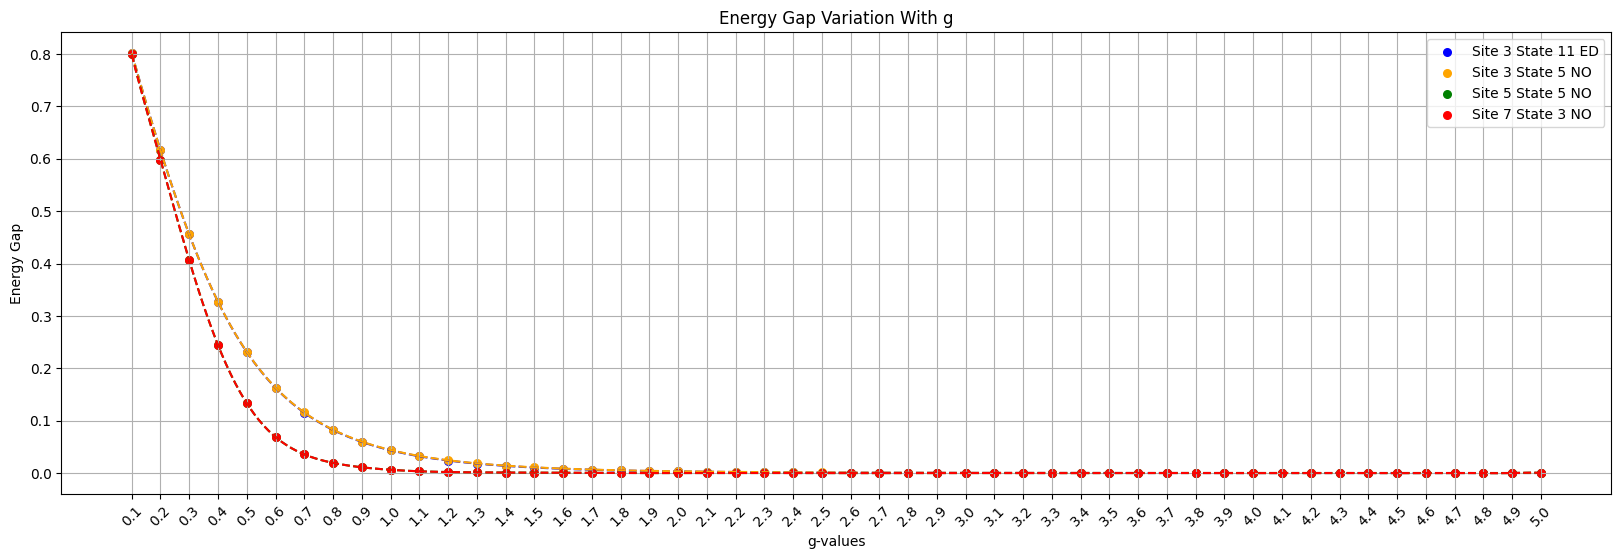

In [ ]:
si3_st11_ED = np.array(si3_st11_ED)
si3_st5_NO = np.array(si3_st5_NO)
si5_st5_NO = np.array(si5_st5_NO)
si7_st3_NO = np.array(si7_st3_NO)
g_array = np.array(g_array)

dim_fit = 20

visible_idx = np.r_[0:10, 19, 49]

plt.figure(figsize=(20, 6))

for y_data, label, color in zip(
    [si3_st11_ED, si3_st5_NO, si5_st5_NO, si7_st3_NO],
    ['Site 3 State 11 ED', 'Site 3 State 5 NO', 'Site 5 State 5 NO', 'Site 7 State 3 NO'],
    ['blue', 'orange', 'green', 'red']
):

    # Fit and plot
    scatter_and_fit(g_array, y_data, label, color, degree=dim_fit)

# Axis formatting
plt.xticks(g_array, rotation=45) 
plt.xlabel("g-values")
plt.ylabel("Energy Gap")
plt.title("Energy Gap Variation With g")
plt.legend()
plt.grid(True)
plt.show()

si3_st11_ED = np.array(si3_st11_ED)
si3_st5_NO = np.array(si3_st5_NO)
si5_st5_NO = np.array(si5_st5_NO)
si7_st3_NO = np.array(si7_st3_NO)
g_array = np.array(g_array)

visible_idx = np.r_[0:10, 19, 49]

# plt.figure(figsize=(20, 6))

# for y_data, label, color in zip(
#     [si3_st11_ED, si3_st5_NO, si5_st5_NO, si7_st3_NO],
#     ['Site 3 State 11 ED', 'Site 3 State 5 NO', 'Site 5 State 5 NO', 'Site 7 State 3 NO'],
#     ['blue', 'orange', 'green', 'red']
# ):

#     # Fit and plot
#     scatter_and_fit(g_array, y_data, label, color, degree=dim_fit, visible_indices=visible_idx)

# # Axis formatting
# plt.xticks(g_array[visible_idx], rotation=45) 
# plt.xlabel("g-values")
# plt.ylabel("Energy Gap")
# plt.title("Energy Gap Variation With g")
# plt.legend()
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(12, 6))

# for y_data, label, color in zip(
#     [si3_st11_ED, si3_st5_NO, si5_st5_NO, si7_st3_NO],
#     ['Site 3 State 11 ED', 'Site 3 State 5 NO', 'Site 5 State 5 NO', 'Site 7 State 3 NO'],
#     ['blue', 'orange', 'green', 'red']
# ):
#     scatter_and_fit_warped(g_array, y_data, label, color, degree=dim_fit, visible_indices=visible_idx)

# # Custom x-ticks
# g_xticks = g_array[np.r_[0:10, 19, 49]]
# plt.xticks(warp_g(g_xticks), labels=[f"{val:.1f}" for val in g_xticks], rotation=45)

# plt.xlabel("g-values")
# plt.ylabel("Energy Gap")
# plt.title("Energy Gap Variation With g")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

# Ground State energy per site.

In [15]:
si3_st11_ED = []
si3_st5_NO = []
si5_st5_NO = []
si7_st3_NO = []
g_array = []

for g_index in range(1, 51):
    g = g_index / 10
    g_array.append(g)

    eig_val, eig_vec = load_one_simulation_ED(3, 11, g, file_path_ED)

    index_array = np.argsort(eig_val)
    ground_energy = eig_val[index_array[0]]/3

    si3_st11_ED.append(ground_energy)

    eig_val, eig_vec, _ = load_one_simulation_NO(3, 5, g, file_path_ED)

    index_array = np.argsort(eig_val)
    ground_energy = eig_val[index_array[0]]/3

    si3_st5_NO.append(ground_energy)

    eig_val, eig_vec, _ = load_one_simulation_NO(5, 5, g, file_path_ED)

    index_array = np.argsort(eig_val)
    ground_energy = eig_val[index_array[0]]/5

    si5_st5_NO.append(ground_energy)
    
    eig_val, eig_vec, _ = load_one_simulation_NO(7, 3, g, file_path_ED)

    index_array = np.argsort(eig_val)
    ground_energy = eig_val[index_array[0]]/7

    si7_st3_NO.append(ground_energy)


/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_75107/1165677915.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_75107/1165677915.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_75107/1165677915.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_75107/1165677915.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)


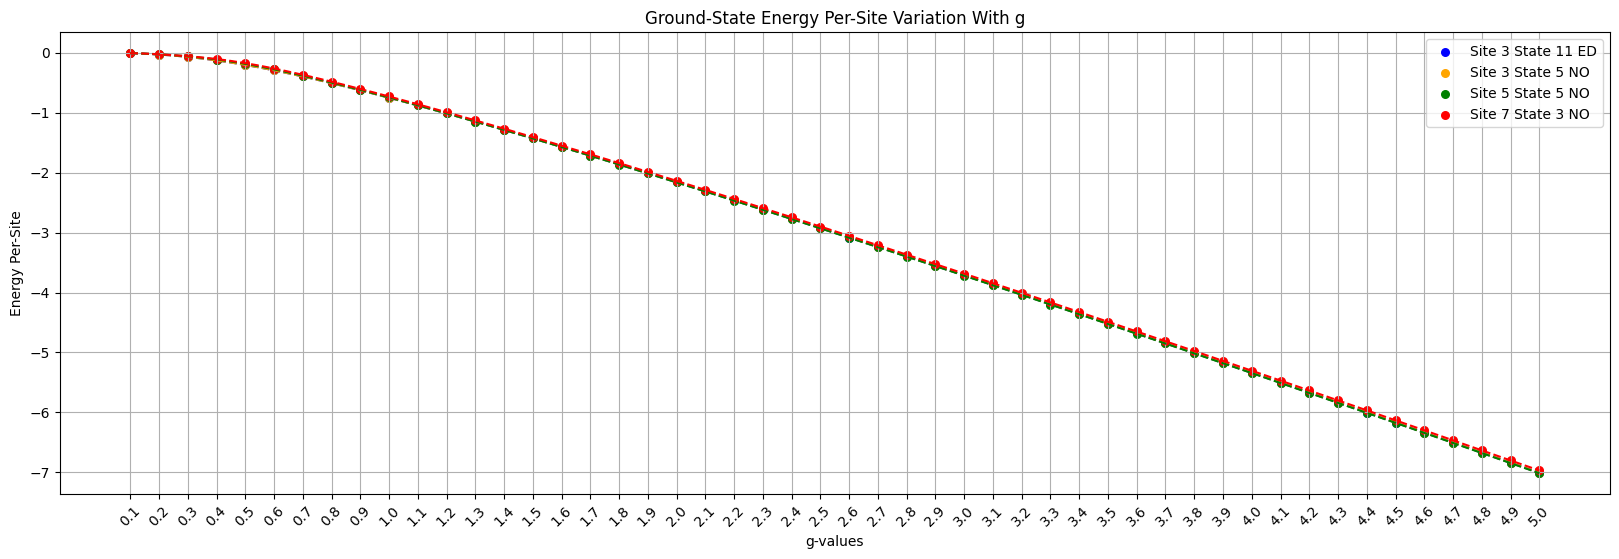

/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_75107/1165677915.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_75107/1165677915.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_75107/1165677915.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_75107/1165677915.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)


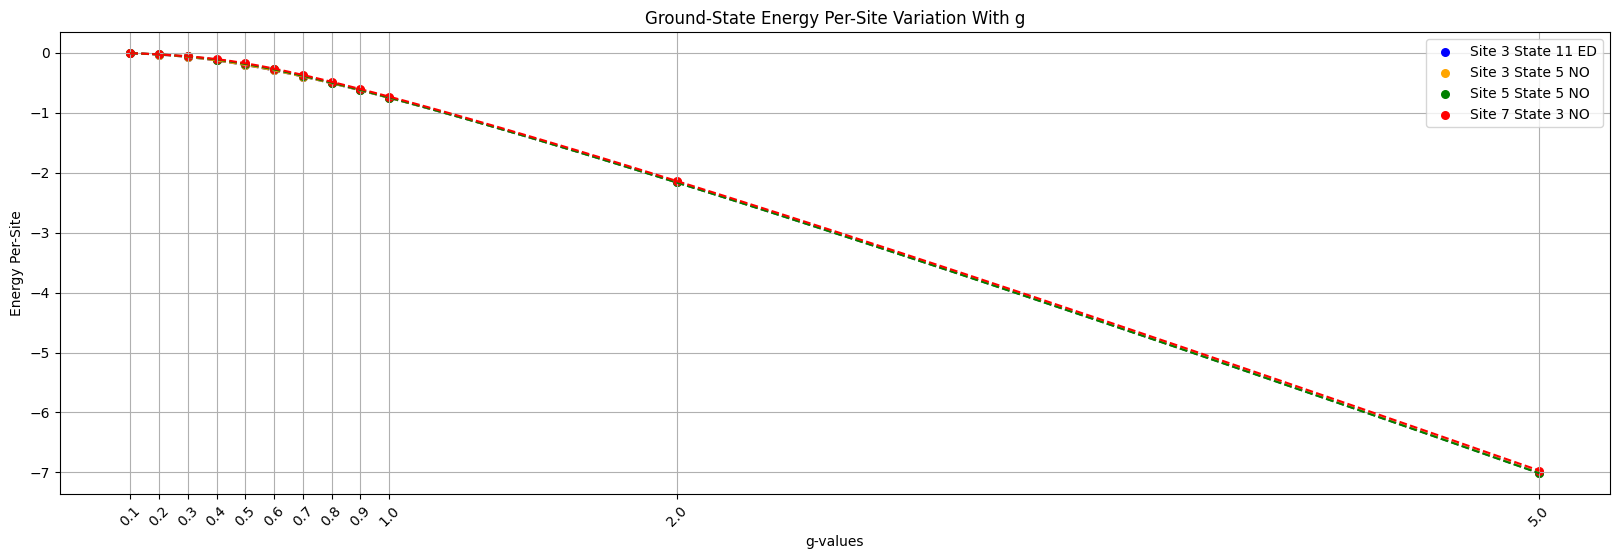

/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_75107/245709048.py:6: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_75107/245709048.py:6: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_75107/245709048.py:6: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_75107/245709048.py:6: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)


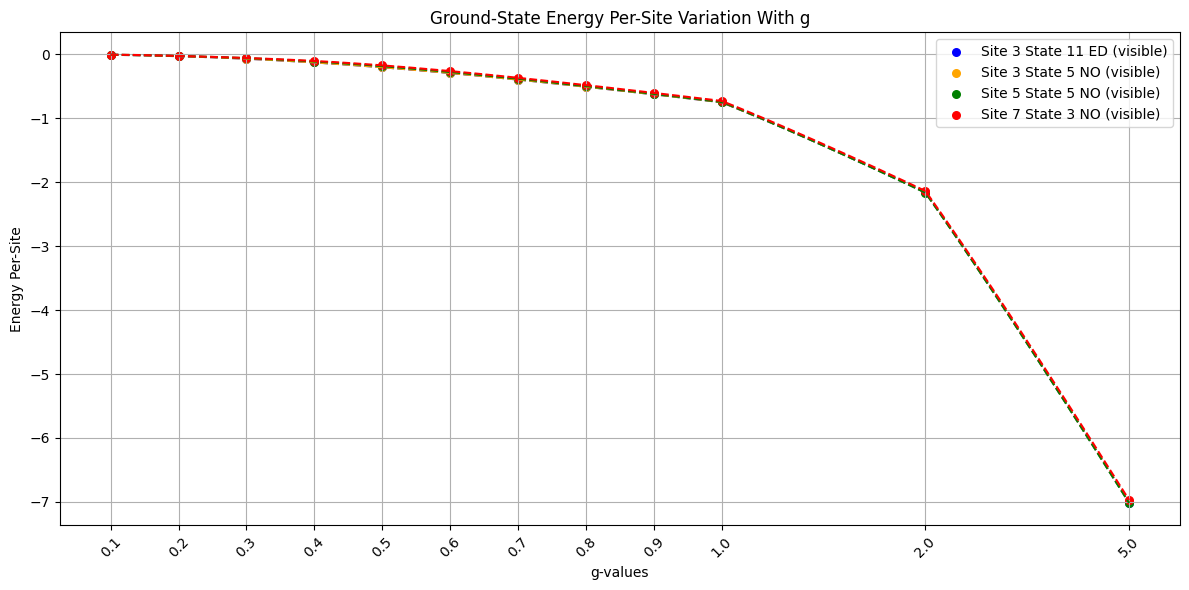

In [16]:
si3_st11_ED = np.array(si3_st11_ED)
si3_st5_NO = np.array(si3_st5_NO)
si5_st5_NO = np.array(si5_st5_NO)
si7_st3_NO = np.array(si7_st3_NO)
g_array = np.array(g_array)

dim_fit = 20

visible_idx = np.r_[0:10, 19, 49]

plt.figure(figsize=(20, 6))

for y_data, label, color in zip(
    [si3_st11_ED, si3_st5_NO, si5_st5_NO, si7_st3_NO],
    ['Site 3 State 11 ED', 'Site 3 State 5 NO', 'Site 5 State 5 NO', 'Site 7 State 3 NO'],
    ['blue', 'orange', 'green', 'red']
):

    # Fit and plot
    scatter_and_fit(g_array, y_data, label, color, degree=dim_fit)

# Axis formatting
plt.xticks(g_array, rotation=45) 
plt.xlabel("g-values")
plt.ylabel("Energy Per-Site")
plt.title("Ground-State Energy Per-Site Variation With g")
plt.legend()
plt.grid(True)
plt.show()

si3_st11_ED = np.array(si3_st11_ED)
si3_st5_NO = np.array(si3_st5_NO)
si5_st5_NO = np.array(si5_st5_NO)
si7_st3_NO = np.array(si7_st3_NO)
g_array = np.array(g_array)

visible_idx = np.r_[0:10, 19, 49]

plt.figure(figsize=(20, 6))

for y_data, label, color in zip(
    [si3_st11_ED, si3_st5_NO, si5_st5_NO, si7_st3_NO],
    ['Site 3 State 11 ED', 'Site 3 State 5 NO', 'Site 5 State 5 NO', 'Site 7 State 3 NO'],
    ['blue', 'orange', 'green', 'red']
):

    # Fit and plot
    scatter_and_fit(g_array, y_data, label, color, degree=dim_fit, visible_indices=visible_idx)

# Axis formatting
plt.xticks(g_array[visible_idx], rotation=45) 
plt.xlabel("g-values")
plt.ylabel("Energy Per-Site")
plt.title("Ground-State Energy Per-Site Variation With g")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))

for y_data, label, color in zip(
    [si3_st11_ED, si3_st5_NO, si5_st5_NO, si7_st3_NO],
    ['Site 3 State 11 ED', 'Site 3 State 5 NO', 'Site 5 State 5 NO', 'Site 7 State 3 NO'],
    ['blue', 'orange', 'green', 'red']
):
    scatter_and_fit_warped(g_array, y_data, label, color, degree=dim_fit, visible_indices=visible_idx)

# Custom x-ticks
g_xticks = g_array[np.r_[0:10, 19, 49]]
plt.xticks(warp_g(g_xticks), labels=[f"{val:.1f}" for val in g_xticks], rotation=45)

plt.xlabel("g-values")
plt.ylabel("Energy Per-Site")
plt.title("Ground-State Energy Per-Site Variation With g")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
si7_st7_NO = []
g_array = []

for g_index in range(1, 21):
    g = g_index / 10
    g_array.append(g)
    
    eig_val, eig_vec, _ = load_one_simulation_NO(7, 7, g, file_path_ED_s)

    index_array = np.argsort(eig_val)
    ground_energy = eig_val[index_array[0]]/7

    si7_st7_NO.append(ground_energy)

dE/dg – dE/dg at g ≈ 1.650 is -1.452534


/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_75107/1165677915.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)


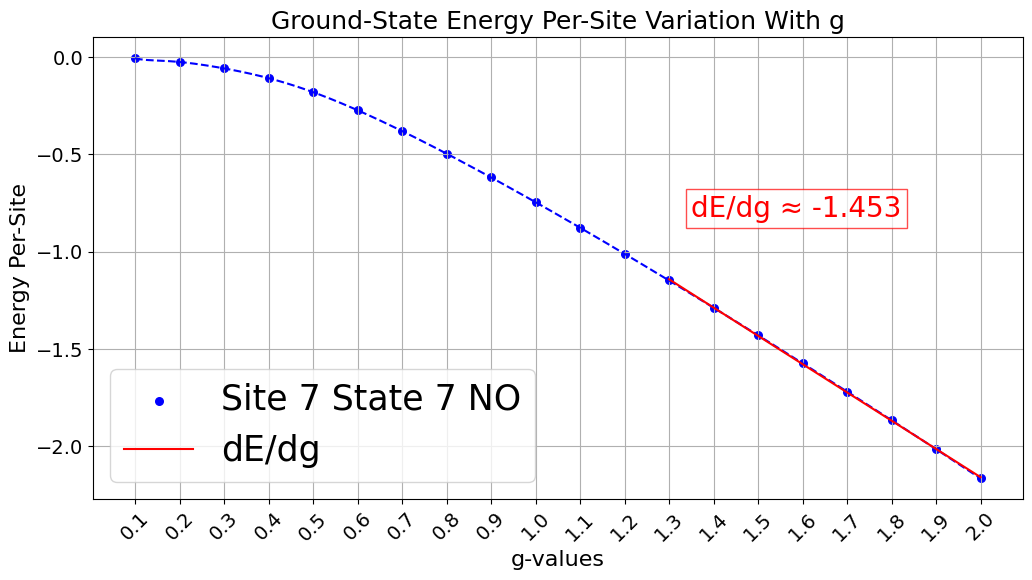

In [18]:
si7_st7_NO = np.array(si7_st7_NO)
g_array = np.array(g_array)

dim_fit = 20

visible_idx = np.r_[0:10, 19, 49]

plt.figure(figsize=(12, 6))

# Update global font size
plt.rcParams.update({
    'font.size': 14,              # Larger font for all text
    'legend.fontsize': 25,        # Larger legend text
    'axes.labelsize': 16,         # Axis labels
    'xtick.labelsize': 14,        # Tick labels
    'ytick.labelsize': 14
})

for y_data, label, color in zip(
    [si7_st7_NO],
    ['Site 7 State 7 NO'],
    ['blue']
):

    # Fit and plot
    scatter_and_fit(g_array, y_data, label, color, degree=dim_fit)

    # Add slope fit between g = 0.2 and g = 0.4
    fit_and_display_slope_in_range(g_array, si7_st7_NO, g_min=1.3, g_max=2.0, label="dE/dg", color="red", degree=1)
# Axis formatting
plt.xticks(g_array, rotation=45) 
plt.xlabel("g-values")
plt.ylabel("Energy Per-Site")
plt.title("Ground-State Energy Per-Site Variation With g", fontsize=18)
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Energy gap for two smallest non-zero eigenstates.

In [19]:
def find_two_smallest_with_indices(eig_val, eig_vec_cut, tol=1e-4):
    """
    Find the two smallest values from `eig_val` where the corresponding `eig_vec_cut` is approximately non-zero.

    Parameters:
        eig_val (array-like): Eigenvalues.
        eig_vec_cut (array-like): Matching vector; we keep entries where abs() > tol.
        tol (float): Tolerance to consider a value as non-zero.

    Returns:
        List of two (value, original_index) tuples sorted by value.
    """
    eig_val = np.asarray(eig_val)
    eig_vec_cut = np.asarray(eig_vec_cut)

    if eig_val.shape != eig_vec_cut.shape:
        raise ValueError("Input arrays must have the same shape.")

    # Step 1: Combine and sort by eigenvalue
    combined = sorted([(val, idx) for idx, val in enumerate(eig_val)])

    # Step 2: Select two smallest where corresponding eig_vec_cut is not approximately zero
    filtered = [(val, idx) for val, idx in combined if np.abs(eig_vec_cut[idx]) > tol]

    if len(filtered) < 2:
        raise ValueError("Not enough approximately non-zero entries found.")

    return filtered[:2]

In [20]:
def min_where_other_is_zero(values, mask, tol=1e-6):
    """
    Find the smallest value from `values`, in sorted order, where the corresponding element in `mask` is approximately zero.

    Parameters:
        values (array-like): Array of numerical values.
        mask (array-like): Array used to filter; selects where abs(mask) < tol.
        tol (float): Tolerance for treating mask values as zero.

    Returns:
        The first value (from sorted `values`) where mask is approximately zero, or None if none found.
    """
    values = np.asarray(values)
    mask = np.asarray(mask)

    if values.shape != mask.shape:
        raise ValueError("Input arrays must have the same shape.")

    # Sort values and apply the same ordering to mask
    sort_idx = np.argsort(values)
    values_sorted = values[sort_idx]
    mask_sorted = mask[sort_idx]

    # Find the first value where mask is approximately zero
    for v, m in zip(values_sorted, mask_sorted):
        if np.abs(m) < tol:
            return v

    return None  # if no match found

In [21]:
def compute_next_eigenpairs(h_sparse, eigvals_prev, count=10, epsilon=1e-8):
    """
    Compute the next `count` eigenpairs after the ones in `eigvals_prev` using spectral shift.
    """
    sigma_shift = eigvals_prev[-1] + epsilon

    # Compute eigenvalues around the shift
    eigvals, eigvecs = eigsh(h_sparse, k=count + 5, sigma=sigma_shift, which='LM')

    # Filter only the values strictly greater than known set
    mask = eigvals > eigvals_prev[-1] + 1e-8
    eigvals_filtered = eigvals[mask]
    eigvecs_filtered = eigvecs[:, mask]

    # Sort by ascending eigenvalue
    order = np.argsort(eigvals_filtered)
    eigvals_sorted = eigvals_filtered[order]
    eigvecs_sorted = eigvecs_filtered[:, order]

    return eigvals_sorted[:count], eigvecs_sorted[:, :count]

In [22]:
si3_st11_ED = []
si3_st5_NO = []
si5_st5_NO = []
si7_st3_NO = []
g_array = []

for g_index in range(1, 51):
    g = g_index / 10
    g_array.append(g)

    eig_val, eig_vec = load_one_simulation_ED(3, 11, g, file_path_ED)
    E_diff = find_two_smallest_with_indices(eig_val, eig_vec[0,:])[1][0] - find_two_smallest_with_indices(eig_val, eig_vec[0,:])[0][0]
    si3_st11_ED.append(E_diff)

    eig_val, eig_vec, _ = load_one_simulation_NO(3, 5, g, file_path_ED)
    E_diff = find_two_smallest_with_indices(eig_val, eig_vec[0,:])[1][0] - find_two_smallest_with_indices(eig_val, eig_vec[0,:])[0][0]
    si3_st5_NO.append(E_diff)

    eig_val, eig_vec, _ = load_one_simulation_NO(5, 5, g, file_path_ED)
    E_diff = find_two_smallest_with_indices(eig_val, eig_vec[0,:])[1][0] - find_two_smallest_with_indices(eig_val, eig_vec[0,:])[0][0]
    si5_st5_NO.append(E_diff)
    
    eig_val, eig_vec, _ = load_one_simulation_NO(7, 3, g, file_path_ED)
    E_diff = find_two_smallest_with_indices(eig_val, eig_vec[0,:])[1][0] - find_two_smallest_with_indices(eig_val, eig_vec[0,:])[0][0]
    si7_st3_NO.append(E_diff)

/Users/gilfrim/Desktop/Projects/Computational_Analisis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/gilfrim/Desktop/Projects/Computational_Analisis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_75107/1165677915.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/Users/gilfrim/Desktop/Projects/Computational_Analisis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_75107/1165677915.py:26: RankWar

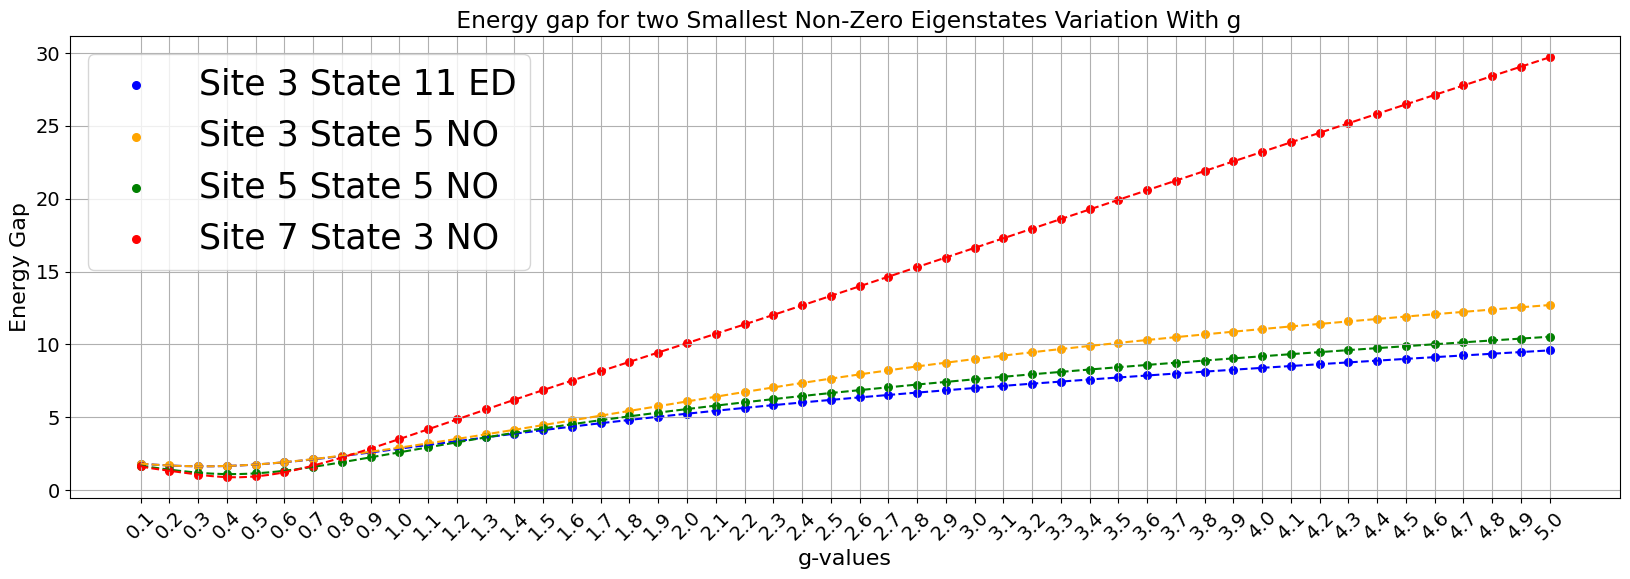

/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_75107/1165677915.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_75107/1165677915.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_75107/1165677915.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_75107/1165677915.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)


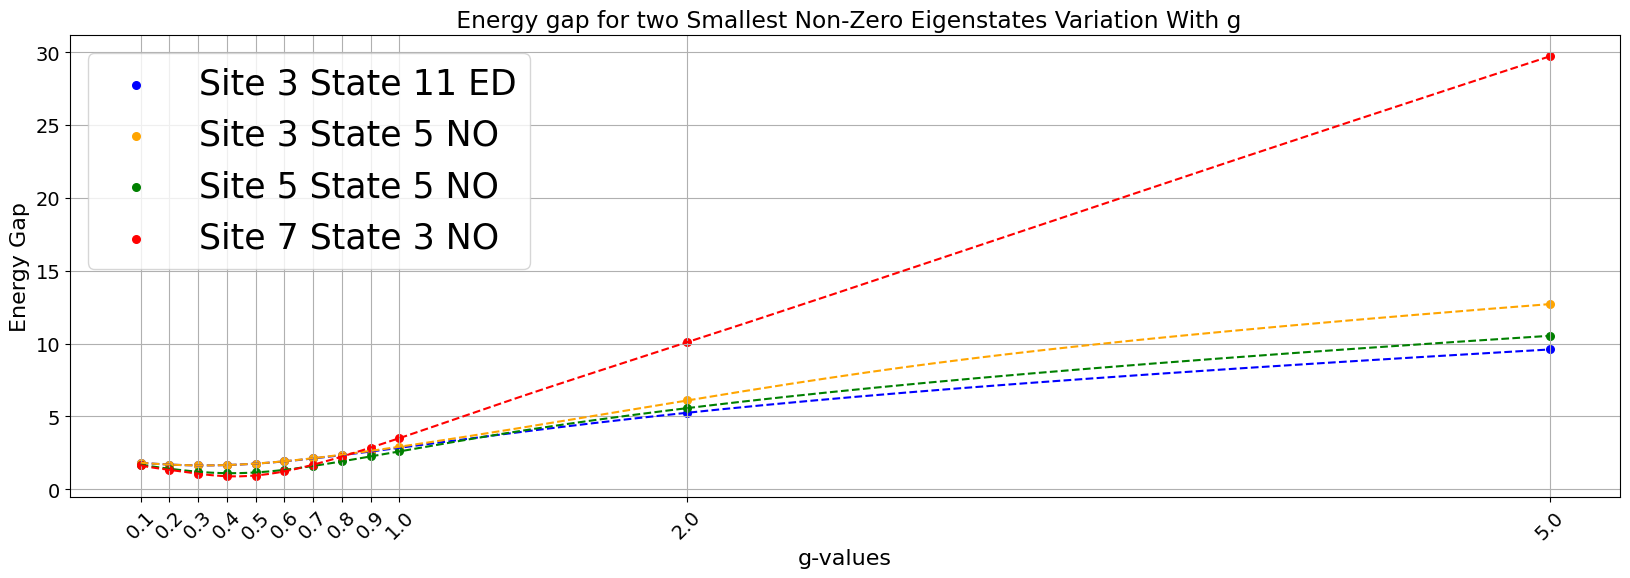

/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_75107/245709048.py:6: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_75107/245709048.py:6: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_75107/245709048.py:6: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_75107/245709048.py:6: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)


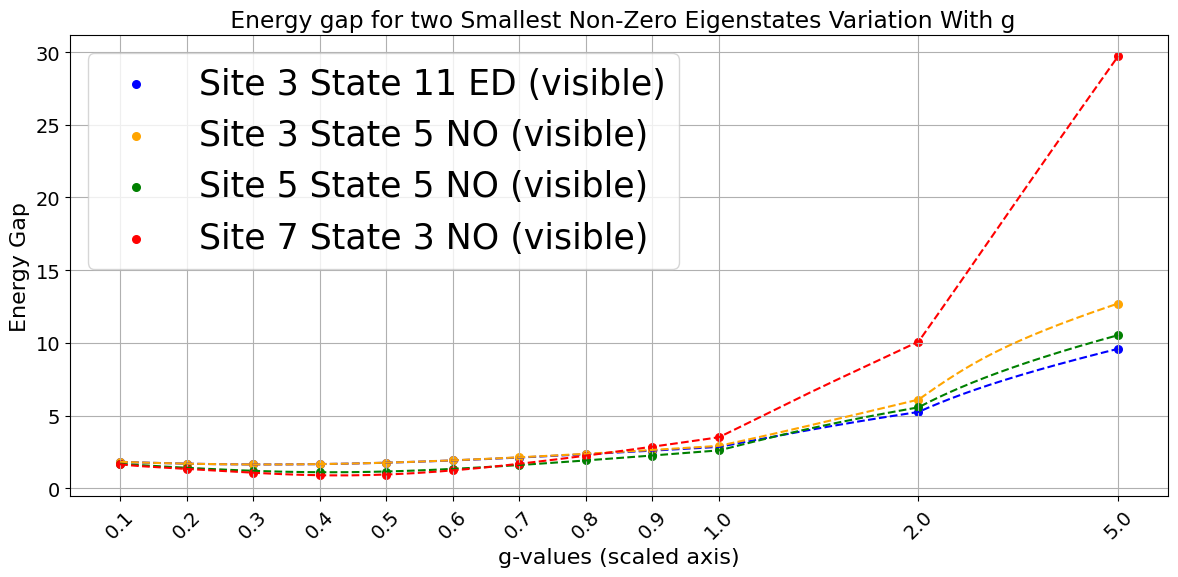

In [23]:
si3_st11_ED = np.array(si3_st11_ED)
si3_st5_NO = np.array(si3_st5_NO)
si5_st5_NO = np.array(si5_st5_NO)
si7_st3_NO = np.array(si7_st3_NO)
g_array = np.array(g_array)

dim_fit = 20

visible_idx = np.r_[0:10, 19, 49]

plt.figure(figsize=(20, 6))

for y_data, label, color in zip(
    [si3_st11_ED, si3_st5_NO, si5_st5_NO, si7_st3_NO],
    ['Site 3 State 11 ED', 'Site 3 State 5 NO', 'Site 5 State 5 NO', 'Site 7 State 3 NO'],
    ['blue', 'orange', 'green', 'red']
):

    # Fit and plot
    scatter_and_fit(g_array, y_data, label, color, degree=dim_fit)

# Axis formatting
plt.xticks(g_array, rotation=45) 
plt.xlabel("g-values")
plt.ylabel("Energy Gap")
plt.title(" Energy gap for two Smallest Non-Zero Eigenstates Variation With g")
plt.legend()
plt.grid(True)
plt.show()

si3_st11_ED = np.array(si3_st11_ED)
si3_st5_NO = np.array(si3_st5_NO)
si5_st5_NO = np.array(si5_st5_NO)
si7_st3_NO = np.array(si7_st3_NO)
g_array = np.array(g_array)

visible_idx = np.r_[0:10, 19, 49]

plt.figure(figsize=(20, 6))

for y_data, label, color in zip(
    [si3_st11_ED, si3_st5_NO, si5_st5_NO, si7_st3_NO],
    ['Site 3 State 11 ED', 'Site 3 State 5 NO', 'Site 5 State 5 NO', 'Site 7 State 3 NO'],
    ['blue', 'orange', 'green', 'red']
):

    # Fit and plot
    scatter_and_fit(g_array, y_data, label, color, degree=dim_fit, visible_indices=visible_idx)

# Axis formatting
plt.xticks(g_array[visible_idx], rotation=45) 
plt.xlabel("g-values")
plt.ylabel("Energy Gap")
plt.title(" Energy gap for two Smallest Non-Zero Eigenstates Variation With g")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))

for y_data, label, color in zip(
    [si3_st11_ED, si3_st5_NO, si5_st5_NO, si7_st3_NO],
    ['Site 3 State 11 ED', 'Site 3 State 5 NO', 'Site 5 State 5 NO', 'Site 7 State 3 NO'],
    ['blue', 'orange', 'green', 'red']
):
    scatter_and_fit_warped(g_array, y_data, label, color, degree=dim_fit, visible_indices=visible_idx)

# Custom x-ticks
g_xticks = g_array[np.r_[0:10, 19, 49]]
plt.xticks(warp_g(g_xticks), labels=[f"{val:.1f}" for val in g_xticks], rotation=45)

plt.xlabel("g-values (scaled axis)")
plt.ylabel("Energy Gap")
plt.title(" Energy gap for two Smallest Non-Zero Eigenstates Variation With g")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 3 site comparison

In [24]:
si3_st11_NO_sym = np.zeros((3, 20), dtype=complex)
g_array = []

for g_index in range(1, 21):
    g = g_index / 10
    g_array.append(g)
    
    eig_val, eig_vec= load_one_simulation_ED(3, 11, g, file_path_ED)

    E_diff_sym = find_two_smallest_with_indices(eig_val, eig_vec[0,:])[1][0] - find_two_smallest_with_indices(eig_val, eig_vec[0,:])[0][0]
    si3_st11_NO_sym[0,g_index-1] = E_diff_sym

    eig_val, eig_vec, _ = load_one_simulation_NO(3, 5, g, file_path_ED)

    E_diff_sym = find_two_smallest_with_indices(eig_val, eig_vec[0,:])[1][0] - find_two_smallest_with_indices(eig_val, eig_vec[0,:])[0][0]
    si3_st11_NO_sym[1,g_index-1] = E_diff_sym

    eig_val, eig_vec, _ = load_one_simulation_NO(3, 7, g, file_path_ED_s)

    E_diff_sym = find_two_smallest_with_indices(eig_val, eig_vec[0,:])[1][0] - find_two_smallest_with_indices(eig_val, eig_vec[0,:])[0][0]
    si3_st11_NO_sym[2,g_index-1] = E_diff_sym

/Users/gilfrim/Desktop/Projects/Computational_Analisis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/gilfrim/Desktop/Projects/Computational_Analisis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/gilfrim/Desktop/Projects/Computational_Analisis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


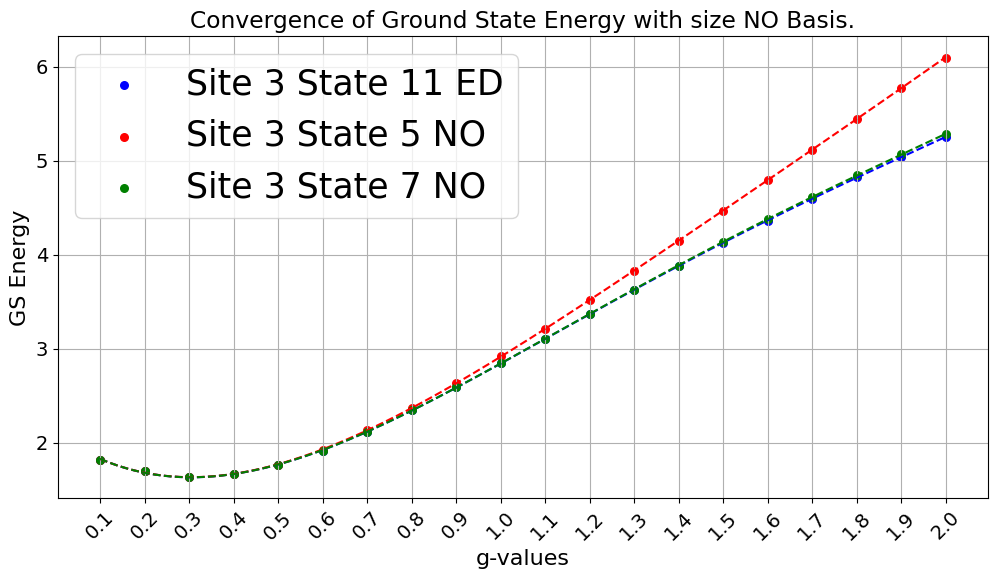

In [25]:
g_array = np.array(g_array)

dim_fit = 5

plt.figure(figsize=(12, 6))

for y_data, label, color in zip(
    [si3_st11_NO_sym[0, :], si3_st11_NO_sym[1, :], si3_st11_NO_sym[2, :]],
    ['Site 3 State 11 ED', 'Site 3 State 5 NO', 'Site 3 State 7 NO'],
    ['blue', "red", 'green']
):

    # Fit and plot
    scatter_and_fit(g_array, y_data, label, color, degree=dim_fit)
# Axis formatting
plt.xticks(g_array, rotation=45) 
plt.xlabel("g-values")
plt.ylabel("GS Energy")
plt.title("Convergence of Ground State Energy with size NO Basis.")
plt.legend()
plt.grid(True)
plt.show()

# 5 and 7 site comparison

In [26]:
sym_Aym_g_5_7 = np.zeros((3, 20), dtype=complex)
g_array = []

for g_index in range(1, 21):
    g = g_index / 10
    g_array.append(g)

    eig_val_5, eig_vec_5, _ = load_one_simulation_NO(5, 9, g, file_path_ED_s)
    E_diff_sym_5 = find_two_smallest_with_indices(eig_val_5, eig_vec_5[0,:])[1][0] - find_two_smallest_with_indices(eig_val_5, eig_vec_5[0,:])[0][0]
    E_diff_Asym_5 = min_where_other_is_zero(eig_val_5, eig_vec_5[0,:]) - find_two_smallest_with_indices(eig_val_5, eig_vec_5[0,:])[0][0]

    eig_val_7, eig_vec_7, _ = load_one_simulation_NO(7, 5, g, file_path_ED_s)
    E_diff_sym_7 = find_two_smallest_with_indices(eig_val_7, eig_vec_7[0,:])[1][0] - find_two_smallest_with_indices(eig_val_7, eig_vec_7[0,:])[0][0]
    E_diff_Asym_7 = min_where_other_is_zero(eig_val_7, eig_vec_7[0,:]) - find_two_smallest_with_indices(eig_val_7, eig_vec_7[0,:])[0][0]

    sym_Aym_g_5_7[0,g_index-1] = E_diff_sym_5 - E_diff_sym_7
    sym_Aym_g_5_7[1,g_index-1] = E_diff_Asym_5 - E_diff_Asym_7
    sym_Aym_g_5_7[2,g_index-1] = find_two_smallest_with_indices(eig_val_5, eig_vec_5[0,:])[0][0] - find_two_smallest_with_indices(eig_val_7, eig_vec_7[0,:])[0][0]

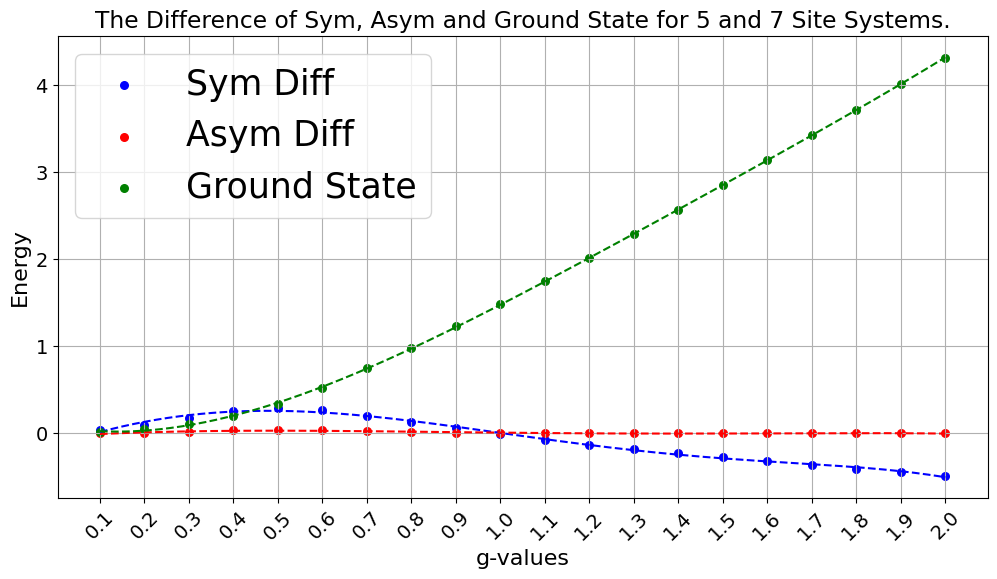

In [27]:
g_array = np.array(g_array)

dim_fit = 5

plt.figure(figsize=(12, 6))

for y_data, label, color in zip(
    [sym_Aym_g_5_7[0, :], sym_Aym_g_5_7[1, :], sym_Aym_g_5_7[2, :]],
    ['Sym Diff', 'Asym Diff', 'Ground State'],
    ['blue', "red", 'green']
):

    # Fit and plot
    scatter_and_fit(g_array, y_data, label, color, degree=dim_fit)
# Axis formatting
plt.xticks(g_array, rotation=45) 
plt.xlabel("g-values")
plt.ylabel("Energy")
plt.title("The Difference of Sym, Asym and Ground State for 5 and 7 Site Systems.")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
sym_Aym_g_5 = np.zeros((6, 20), dtype=complex)
g_array = []

for g_index in range(1, 21):
    g = g_index / 10
    g_array.append(g)

    print(f"g-val: {g}")

    eig_val_5, eig_vec_5, _ = load_one_simulation_NO(5, 9, g, file_path_ED_s)
    E_diff_sym_5 = find_two_smallest_with_indices(eig_val_5, eig_vec_5[0,:])[1][0] - find_two_smallest_with_indices(eig_val_5, eig_vec_5[0,:])[0][0]
    E_diff_Asym_5 = min_where_other_is_zero(eig_val_5, eig_vec_5[0,:]) - find_two_smallest_with_indices(eig_val_5, eig_vec_5[0,:])[0][0]

    print(f"5 SitesC_0=0: {min_where_other_is_zero(eig_val_5, eig_vec_5[0,:])}")
    print(f"5 Ground Energy: {find_two_smallest_with_indices(eig_val_5, eig_vec_5[0,:])[0][0]}")
    print(f"5 Asym: {E_diff_Asym_5}")
    print("\n")

    eig_val_7, eig_vec_7, _ = load_one_simulation_NO(7, 5, g, file_path_ED_s)
    E_diff_sym_7 = find_two_smallest_with_indices(eig_val_7, eig_vec_7[0,:])[1][0] - find_two_smallest_with_indices(eig_val_7, eig_vec_7[0,:])[0][0]
    E_diff_Asym_7 = min_where_other_is_zero(eig_val_7, eig_vec_7[0,:]) - find_two_smallest_with_indices(eig_val_7, eig_vec_7[0,:])[0][0]

    print(f"7 SitesC_0=0: {min_where_other_is_zero(eig_val_7, eig_vec_7[0,:])}")
    print(f"7 Ground Energy: {find_two_smallest_with_indices(eig_val_7, eig_vec_7[0,:])[0][0]}")
    print(f"7 Asym: {E_diff_Asym_7}")

    print("\n")
    print(f"5 Asym - 7 Asym: {E_diff_Asym_5 - E_diff_Asym_7}")
    print("\n")


    sym_Aym_g_5[0,g_index-1] = E_diff_sym_5
    sym_Aym_g_5[1,g_index-1] = E_diff_Asym_5
    sym_Aym_g_5[2,g_index-1] = find_two_smallest_with_indices(eig_val_5, eig_vec_5[0,:])[0][0]
    sym_Aym_g_5[3,g_index-1] = E_diff_sym_7
    sym_Aym_g_5[4,g_index-1] = E_diff_Asym_7
    sym_Aym_g_5[5,g_index-1] = find_two_smallest_with_indices(eig_val_7, eig_vec_7[0,:])[0][0]

g-val: 0.1
5 SitesC_0=0: 0.7678357252919441
5 Ground Energy: -0.03137634218679425
5 Asym: 0.7992120674787384


7 SitesC_0=0: 0.7552672158257574
7 Ground Energy: -0.04386935040112988
7 Asym: 0.7991365662268872


5 Asym - 7 Asym: 7.550125185118439e-05


g-val: 0.2
5 SitesC_0=0: 0.47032434523415817
5 Ground Energy: -0.12772779048128036
5 Asym: 0.5980521357154385


7 SitesC_0=0: 0.41871505062844067
7 Ground Energy: -0.17715963773162585
7 Asym: 0.5958746883600665


5 Asym - 7 Asym: 0.002177447355371953


g-val: 0.3
5 SitesC_0=0: 0.10771444611418055
5 Ground Energy: -0.29832810741158466
5 Asym: 0.40604255352576524


7 SitesC_0=0: -0.014433930157292453
7 Ground Energy: -0.4075881667296619
7 Asym: 0.3931542365723695


5 Asym - 7 Asym: 0.012888316953395762


g-val: 0.4
5 SitesC_0=0: -0.3160092940321282
5 Ground Energy: -0.5604030796098058
5 Asym: 0.24439378557767766


7 SitesC_0=0: -0.5466802966170922
7 Ground Energy: -0.7578335002090787
7 Asym: 0.21115320359198653


5 Asym - 7 Asym: 0.03324058

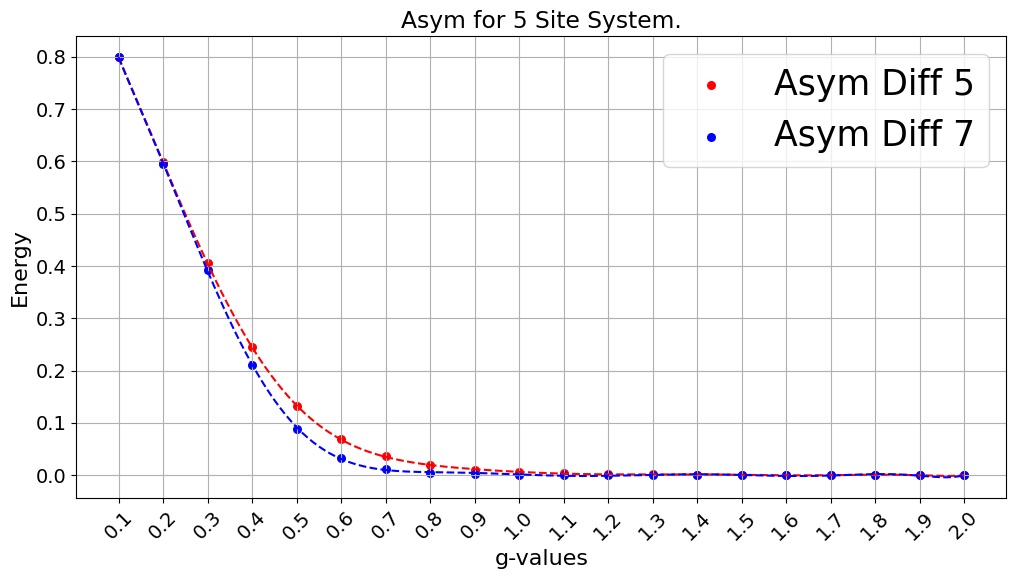

In [29]:
g_array = np.array(g_array)

dim_fit = 10

plt.figure(figsize=(12, 6))

for y_data, label, color in zip(
    [sym_Aym_g_5[1, :], sym_Aym_g_5[4, :]],
    ['Asym Diff 5', 'Asym Diff 7'],
    ["red", 'blue']
):

    # Fit and plot
    scatter_and_fit(g_array, y_data, label, color, degree=dim_fit)
# Axis formatting
plt.xticks(g_array, rotation=45) 
plt.xlabel("g-values")
plt.ylabel("Energy")
plt.title("Asym for 5 Site System.")
plt.legend()
plt.grid(True)
plt.show()

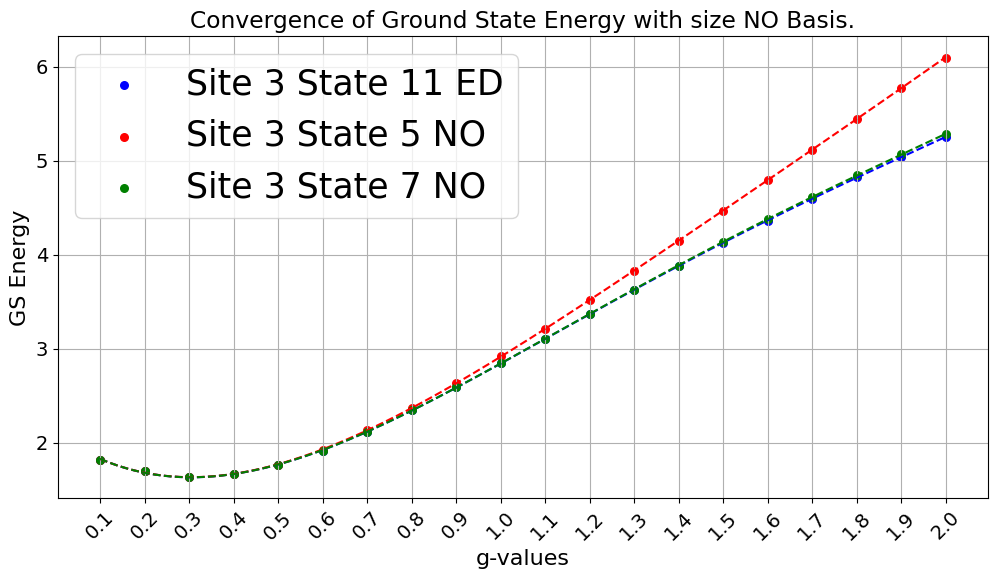

In [30]:
g_array = np.array(g_array)

dim_fit = 5

plt.figure(figsize=(12, 6))

for y_data, label, color in zip(
    [si3_st11_NO_sym[0, :], si3_st11_NO_sym[1, :], si3_st11_NO_sym[2, :]],
    ['Site 3 State 11 ED', 'Site 3 State 5 NO', 'Site 3 State 7 NO'],
    ['blue', "red", 'green']
):

    # Fit and plot
    scatter_and_fit(g_array, y_data, label, color, degree=dim_fit)
# Axis formatting
plt.xticks(g_array, rotation=45) 
plt.xlabel("g-values")
plt.ylabel("GS Energy")
plt.title("Convergence of Ground State Energy with size NO Basis.")
plt.legend()
plt.grid(True)
plt.show()

## 5 5 system

In [31]:
si7_st7_NO_sym = []
si7_st7_NO_Asym = []
g_array = []

for g_index in range(1, 21):
    g = g_index / 10
    g_array.append(g)
    
    eig_val, eig_vec, _ = load_one_simulation_NO(7, 5, g, file_path_ED_s)

    index_array = np.argsort(eig_val)
    ground_energy = eig_val[index_array]

    E_diff_sym = find_two_smallest_with_indices(eig_val, eig_vec[0,:])[1][0] - find_two_smallest_with_indices(eig_val, eig_vec[0,:])[0][0]
    si7_st7_NO_sym.append(E_diff_sym)

    E_diff_Asym = min_where_other_is_zero(eig_val, eig_vec[0,:]) - find_two_smallest_with_indices(eig_val, eig_vec[0,:])[0][0]
    si7_st7_NO_Asym.append(E_diff_Asym)

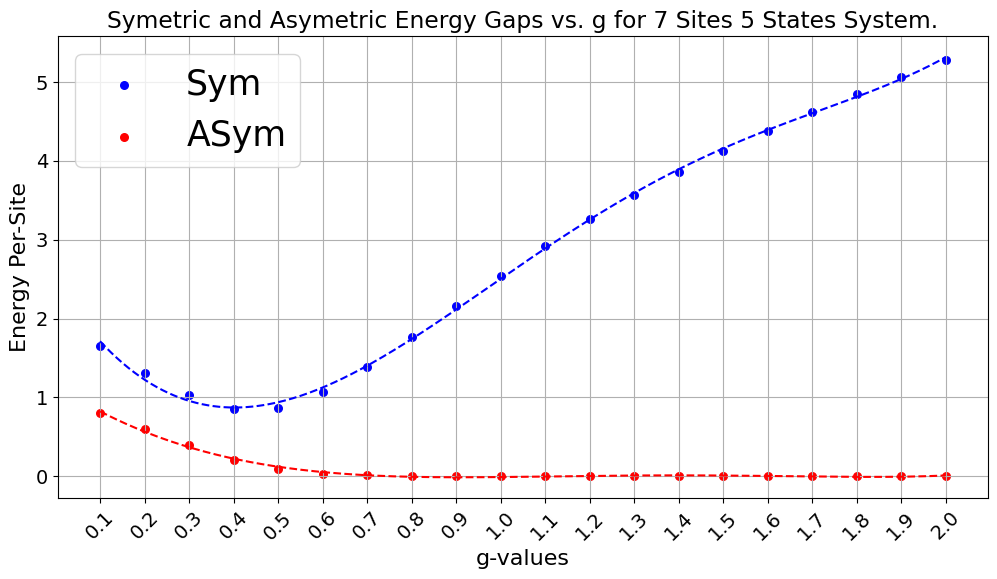

In [32]:
si7_st7_NO_sym = np.array(si7_st7_NO_sym)
si7_st7_NO_Asym = np.array(si7_st7_NO_Asym)
g_array = np.array(g_array)

dim_fit = 5

visible_idx = np.r_[0:10, 19, 49]

plt.figure(figsize=(12, 6))

for y_data, label, color in zip(
    [si7_st7_NO_sym, si7_st7_NO_Asym],
    ['Sym', 'ASym'],
    ['blue', "red"]
):

    # Fit and plot
    scatter_and_fit(g_array, y_data, label, color, degree=dim_fit)
# Axis formatting
plt.xticks(g_array, rotation=45) 
plt.xlabel("g-values")
plt.ylabel("Energy Per-Site")
plt.title("Symetric and Asymetric Energy Gaps vs. g for 7 Sites 5 States System.")
plt.legend()
plt.grid(True)
plt.show()

## 5 & 7 difference

In [33]:
si3_st11_NO_sym = []
si3_st11_NO_Asym = []
si3_st11_NO_energy_per_site = []
si3_st5_NO_sym = []
si3_st5_NO_Asym = []
si3_st5_NO_energy_per_site = []
g_array = []

for g_index in range(1, 21):
    g = g_index / 10
    g_array.append(g)
    
    eig_val, eig_vec= load_one_simulation_NO(5, 5, g, file_path_ED)

    E_diff_sym = find_two_smallest_with_indices(eig_val, eig_vec[0,:])[1][0] - find_two_smallest_with_indices(eig_val, eig_vec[0,:])[0][0]
    si3_st11_NO_sym.append(E_diff_sym)

    E_diff_Asym = min_where_other_is_zero(eig_val, eig_vec[0,:]) - find_two_smallest_with_indices(eig_val, eig_vec[0,:])[0][0]
    si3_st11_NO_Asym.append(E_diff_Asym)

    index_array = np.argsort(eig_val)
    ground_energy = eig_val[index_array[0]]/3

    si3_st11_NO_energy_per_site.append(ground_energy)

    eig_val, eig_vec, _ = load_one_simulation_NO(3, 5, g, file_path_ED)

    E_diff_sym = find_two_smallest_with_indices(eig_val, eig_vec[0,:])[1][0] - find_two_smallest_with_indices(eig_val, eig_vec[0,:])[0][0]
    si3_st5_NO_sym.append(E_diff_sym)

    E_diff_Asym = min_where_other_is_zero(eig_val, eig_vec[0,:]) - find_two_smallest_with_indices(eig_val, eig_vec[0,:])[0][0]
    si3_st5_NO_Asym.append(E_diff_Asym)

    index_array = np.argsort(eig_val)
    ground_energy = eig_val[index_array[0]]/3

    si3_st5_NO_energy_per_site.append(ground_energy)

ValueError: too many values to unpack (expected 2)

# C_o variation for ground state energy.

In [ ]:
si3_st11_ED = []
si3_st5_NO = []
si5_st5_NO = []
si7_st3_NO = []
g_array = []

for g_index in range(1, 51):
    g = g_index / 10
    g_array.append(g)
    
    eig_val, eig_vec = load_one_simulation_ED(3, 11, g, file_path_ED)

    C_1_0 = eig_vec[0, find_two_smallest_with_indices(eig_val, eig_vec[0,:])[0][1]]

    si3_st11_ED.append(C_1_0)

    eig_val, eig_vec, _ = load_one_simulation_NO(3, 5, g, file_path_ED)

    C_1_0 = eig_vec[0, find_two_smallest_with_indices(eig_val, eig_vec[0,:])[0][1]]

    si3_st5_NO.append(C_1_0)

    eig_val, eig_vec, _ = load_one_simulation_NO(5, 5, g, file_path_ED)

    C_1_0 = eig_vec[0, find_two_smallest_with_indices(eig_val, eig_vec[0,:])[0][1]]

    si5_st5_NO.append(C_1_0)
    
    eig_val, eig_vec, _ = load_one_simulation_NO(7, 3, g, file_path_ED)

    C_1_0 = eig_vec[0, find_two_smallest_with_indices(eig_val, eig_vec[0,:])[0][1]]

    si7_st3_NO.append(C_1_0)


/Users/gilfrim/Desktop/Projects/Computational_Analisis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/gilfrim/Desktop/Projects/Computational_Analisis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/gilfrim/Desktop/Projects/Computational_Analisis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


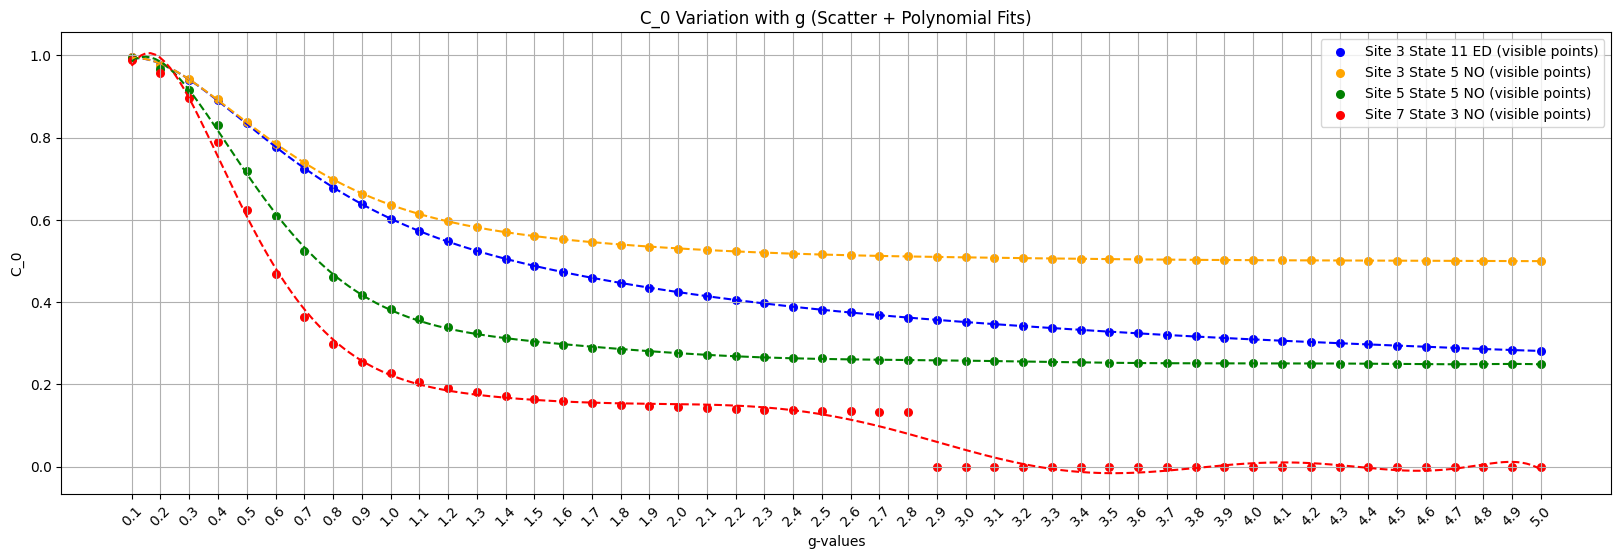

In [ ]:
si3_st11_ED = np.array(si3_st11_ED)
si3_st5_NO = np.array(si3_st5_NO)
si5_st5_NO = np.array(si5_st5_NO)
si7_st3_NO = np.array(si7_st3_NO)
g_array = np.array(g_array)

# plt.figure(figsize=(12, 6))

# bar(g_array, si3_st11_ED, si3_st5_NO, si5_st5_NO, si7_st3_NO)

# # Axis formatting
# plt.xticks(g_array)
# plt.xlabel("g-values")
# plt.ylabel("C_0")
# plt.title("C_0 Variation with g.")
# plt.legend()

# # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.tight_layout()
# plt.show()

plt.figure(figsize=(20, 6))

# Use consistent colors
colors = ['blue', 'orange', 'green', 'red']

scatter_and_fit(g_array, si3_st11_ED, 'Site 3 State 11 ED', colors[0])
scatter_and_fit(g_array, si3_st5_NO,  'Site 3 State 5 NO',  colors[1])
scatter_and_fit(g_array, si5_st5_NO,  'Site 5 State 5 NO',  colors[2])
scatter_and_fit(g_array, si7_st3_NO,  'Site 7 State 3 NO',  colors[3])

# Axis formatting
plt.xticks(g_array, rotation=45) 
plt.xlabel("g-values")
plt.ylabel("C_0")
plt.title("C_0 Variation with g (Scatter + Polynomial Fits)")
plt.legend()
plt.grid(True)
plt.show()

# C_0 variation for second smallest non-zero energystate.

In [ ]:
si3_st11_ED = []
si3_st5_NO = []
si5_st5_NO = []
si7_st3_NO = []
g_array = []

for g_index in range(1, 51):
    g = g_index / 10
    g_array.append(g)

    eig_val, eig_vec = load_one_simulation_ED(3, 11, g, file_path_ED)

    C_1_0 = eig_vec[0, find_two_smallest_with_indices(eig_val, eig_vec[0,:])[1][1]]

    si3_st11_ED.append(C_1_0)

    eig_val, eig_vec, _ = load_one_simulation_NO(3, 5, g, file_path_ED)

    C_1_0 = eig_vec[0, find_two_smallest_with_indices(eig_val, eig_vec[0,:])[1][1]]

    si3_st5_NO.append(C_1_0)

    eig_val, eig_vec, _ = load_one_simulation_NO(5, 5, g, file_path_ED)

    C_1_0 = eig_vec[0, find_two_smallest_with_indices(eig_val, eig_vec[0,:])[1][1]]

    si5_st5_NO.append(C_1_0)
    
    eig_val, eig_vec, _ = load_one_simulation_NO(7, 3, g, file_path_ED)

    C_1_0 = eig_vec[0, find_two_smallest_with_indices(eig_val, eig_vec[0,:])[1][1]]

    si7_st3_NO.append(C_1_0)


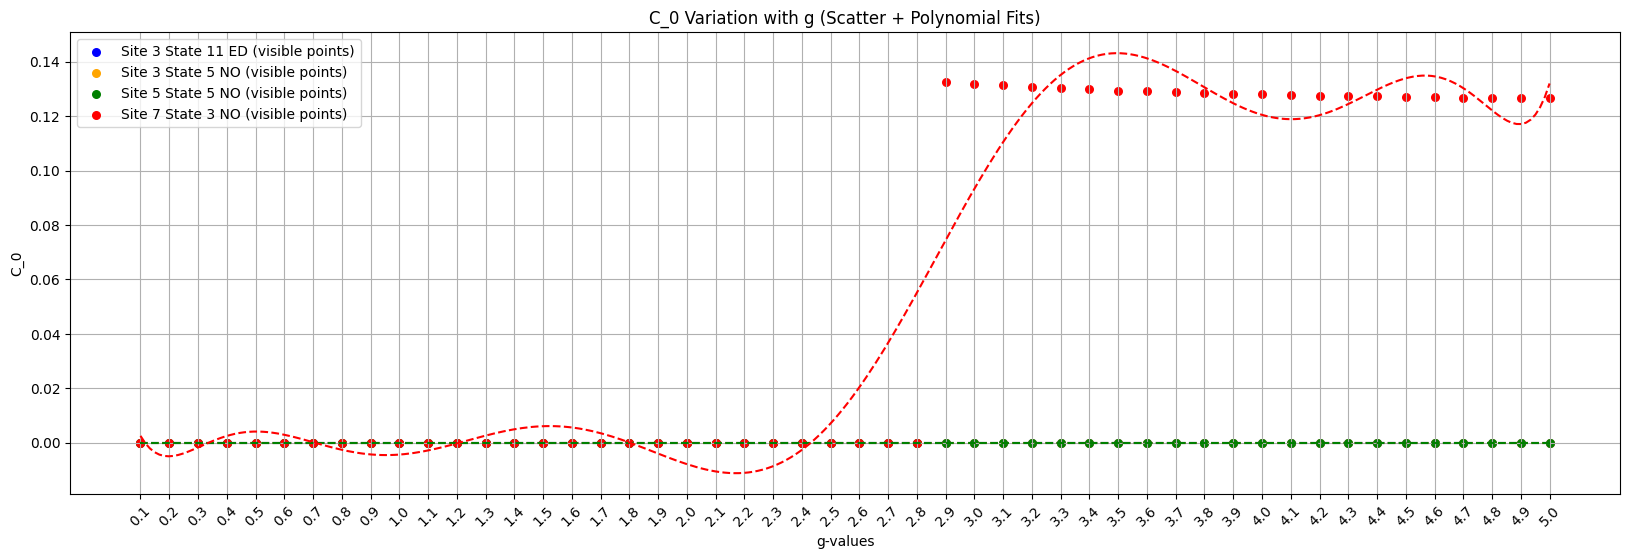

In [ ]:
si3_st11_ED = np.array(si3_st11_ED)
si3_st5_NO = np.array(si3_st5_NO)
si5_st5_NO = np.array(si5_st5_NO)
si7_st3_NO = np.array(si7_st3_NO)
g_array = np.array(g_array)

plt.figure(figsize=(20, 6))

# Use consistent colors
colors = ['blue', 'orange', 'green', 'red']

scatter_and_fit(g_array, si3_st11_ED, 'Site 3 State 11 ED', colors[0])
scatter_and_fit(g_array, si3_st5_NO,  'Site 3 State 5 NO',  colors[1])
scatter_and_fit(g_array, si5_st5_NO,  'Site 5 State 5 NO',  colors[2])
scatter_and_fit(g_array, si7_st3_NO,  'Site 7 State 3 NO',  colors[3])

# Axis formatting
plt.xticks(g_array, rotation=45) 
plt.xlabel("g-values")
plt.ylabel("C_0")
plt.title("C_0 Variation with g (Scatter + Polynomial Fits)")
plt.legend()
plt.grid(True)
plt.show()

# T amplitudes 7, 7

In [ ]:
si7_st7_NO_t_1 = []
si7_st7_NO_t_2 = []
si7_st7_NO_t_3 = []
g_array = []
states = 7
sites = 7

for g_index in range(1, 21):
    g = g_index / 10
    g_array.append(g)

    t_2 = load_one_simulation_t_amplitudes_t_2(7, 7, g, file_path_T_amplitudes)

    t_01 = np.max(np.abs(t_2[0, 1]))
    t_02 = np.max(np.abs(t_2[0, 2]))
    t_03 = np.max(np.abs(t_2[0, 3]))

    si7_st7_NO_t_1.append(t_01)
    si7_st7_NO_t_2.append(t_02)
    si7_st7_NO_t_3.append(t_03)

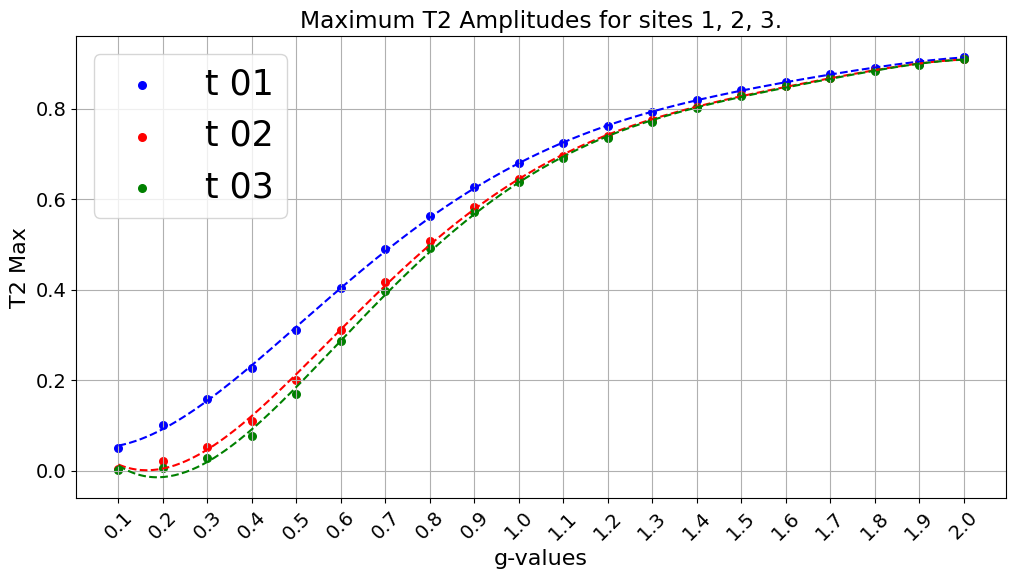

In [ ]:
si7_st7_NO_t_1 = np.array(si7_st7_NO_t_1)
si7_st7_NO_t_2 = np.array(si7_st7_NO_t_2)
si7_st7_NO_t_3 = np.array(si7_st7_NO_t_3)
g_array = np.array(g_array)

dim_fit = 5

visible_idx = np.r_[0:10, 19, 49]

plt.figure(figsize=(12, 6))

for y_data, label, color in zip(
    [si7_st7_NO_t_1, si7_st7_NO_t_2, si7_st7_NO_t_3],
    ['t 01', 't 02', 't 03'],
    ['blue', "red", 'green']
):

    # Fit and plot
    scatter_and_fit(g_array, y_data, label, color, degree=dim_fit)
# Axis formatting
plt.xticks(g_array, rotation=45) 
plt.xlabel("g-values")
plt.ylabel("T2 Max")
plt.title("Maximum T2 Amplitudes for sites 1, 2, 3.")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
t_a_i_tensor_guess = t_1_amplitude_guess_ground_state(states, sites, g, 1, eig_vec, eig_val)
t_ab_ij_tensor_guess = t_2_amplitude_guess_ground_state(states, sites, g, 1, eig_vec, eig_val)

d = intermediate_normalisation(eig_val, eig_vec)
energy_guess = amplitute_energy(sites, states, g, d)

print("Guess:")
print("Energy:", energy_guess)
print(f"1 max: {np.max(np.abs(t_a_i_tensor_guess))}")
print(f"2 max: {np.max(np.abs(t_ab_ij_tensor_guess))}\n")

# T amplitudes for large systems.

In [ ]:

g_vals = np.array([0.1, 0.2, 0.3])
site_vals = np.array([3, 5, 7, 9, 11, 13, 15, 20, 25, 30])

## Save T amplitudes.

In [ ]:
energy_matrix_5 = np.zeros((10, 2), dtype=complex)

for g_index in range(1 ,21):
        g = g_index/10

        print(f"State 7, site {7}, g={g}.")

        eig_val, eig_vec, _ = load_one_simulation_NO(7, 7, g, file_path_ED_s)

        t_2 = t_2_amplitude_guess_ground_state(7, 7, g, 1, eig_vec, eig_val)

        base = f"sites{7}_states{7}_g{g:.2f}"

        # Save to .npy files
        np.save(f"{file_path_T_amplitudes}/t_2{base}.npy", t_2)

State 7, site 7, g=0.1.
State 7, site 7, g=0.2.
State 7, site 7, g=0.3.
State 7, site 7, g=0.4.
State 7, site 7, g=0.5.
State 7, site 7, g=0.6.
State 7, site 7, g=0.7.
State 7, site 7, g=0.8.
State 7, site 7, g=0.9.
State 7, site 7, g=1.0.
State 7, site 7, g=1.1.
State 7, site 7, g=1.2.
State 7, site 7, g=1.3.
State 7, site 7, g=1.4.
State 7, site 7, g=1.5.
State 7, site 7, g=1.6.
State 7, site 7, g=1.7.
State 7, site 7, g=1.8.
State 7, site 7, g=1.9.
State 7, site 7, g=2.0.


In [ ]:
energy_matrix_7 = np.zeros((10, 2), dtype=complex)

for g_index in range(1, 2):
    for site_index in range(10):
            g = g_vals[g_index]
            site = site_vals[site_index]

            print(f"State 7, site {site}, g={g}.")

            energy, t_1, t_2, diverge = t_periodic(site, 7, 1, 0, 0, 1e-8, g, 3,  False, 3, False, "sin")

            energy_matrix_7[site_index, g_index] = energy

            base = f"sites{site}_states{7}_g{g:.2f}"

            # Save to .npy files
            np.save(f"{file_path_T_amplitudes}/t_1{base}.npy", t_1)
            np.save(f"{file_path_T_amplitudes}/t_2{base}.npy", t_2)

np.save(f"{file_path_T_amplitudes}/energy_matrix_7.npy", energy_matrix_7)

State 7, site 3, g=0.2.
State 7, site 5, g=0.2.
State 7, site 7, g=0.2.
State 7, site 9, g=0.2.
State 7, site 11, g=0.2.
State 7, site 13, g=0.2.
State 7, site 15, g=0.2.
State 7, site 20, g=0.2.
State 7, site 25, g=0.2.
State 7, site 30, g=0.2.


## Graph t amplitudes for large systems.

In [ ]:
t_1_amplitude_matrix_5 = np.zeros((10, 10))
t_2_amplitude_matrix_5 = np.zeros((10, 10))

for g_index in range(10):
    for site_index in range(10):
            g = g_vals[g_index]
            site = site_vals[site_index]

            t_1, t_2 = load_one_simulation_t_amplitudes(site, 5, g, file_path_T_amplitudes)
            
            largest_t_1 = np.max(np.abs(t_1))
            largest_t_2 = np.max(np.abs(t_2))

            t_1_amplitude_matrix_5[site_index, g_index] = largest_t_1
            t_2_amplitude_matrix_5[site_index, g_index] = largest_t_2

/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_43369/3831408118.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_43369/3831408118.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_43369/3831408118.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_43369/3831408118.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_43369/3831408118.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_43369/3831408118.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var

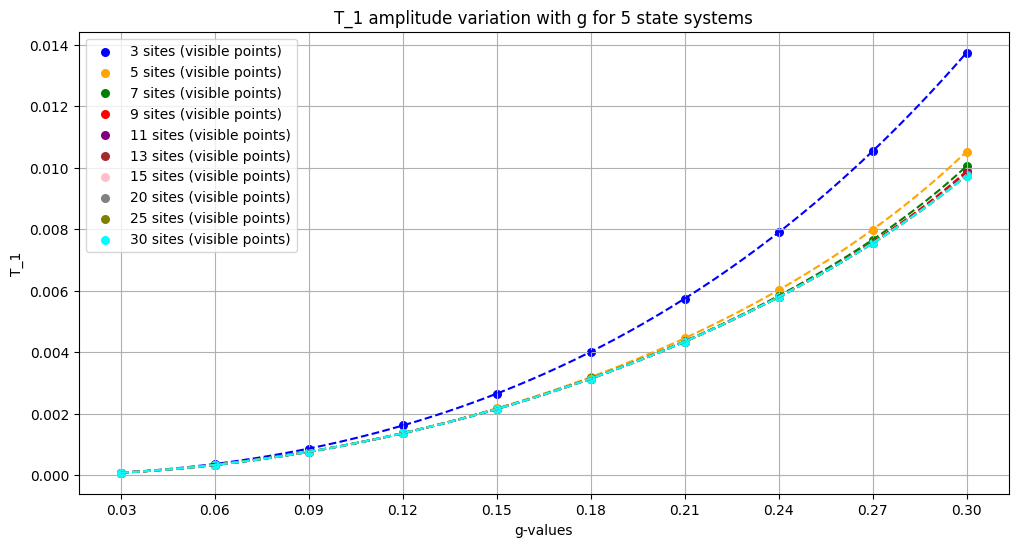

In [ ]:
t_1_3 = t_1_amplitude_matrix_5[0, :]
t_1_5 = t_1_amplitude_matrix_5[1, :]
t_1_7 = t_1_amplitude_matrix_5[2, :]
t_1_9 = t_1_amplitude_matrix_5[3, :]
t_1_11 = t_1_amplitude_matrix_5[4, :]
t_1_13 = t_1_amplitude_matrix_5[5, :]
t_1_15 = t_1_amplitude_matrix_5[6, :]
t_1_20 = t_1_amplitude_matrix_5[7, :]
t_1_25 = t_1_amplitude_matrix_5[8, :]
t_1_30 = t_1_amplitude_matrix_5[9, :]

plt.figure(figsize=(12, 6))

# Use consistent colors
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

scatter_and_fit(g_vals, t_1_3, '3 sites', colors[0])
scatter_and_fit(g_vals, t_1_5, '5 sites',  colors[1])
scatter_and_fit(g_vals, t_1_7, '7 sites',  colors[2])
scatter_and_fit(g_vals, t_1_9, '9 sites',  colors[3])
scatter_and_fit(g_vals, t_1_11, '11 sites',  colors[4])
scatter_and_fit(g_vals, t_1_13, '13 sites',  colors[5])
scatter_and_fit(g_vals, t_1_15, '15 sites',  colors[6])
scatter_and_fit(g_vals, t_1_20, '20 sites',  colors[7])
scatter_and_fit(g_vals, t_1_25, '25 sites',  colors[8])
scatter_and_fit(g_vals, t_1_30, '30 sites',  colors[9])

# Axis formatting
plt.xticks(g_vals)
plt.xlabel("g-values")
plt.ylabel("T_1")
plt.title("T_1 amplitude variation with g for 5 state systems")
plt.legend()
plt.grid(True)
plt.show()

/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_43369/3831408118.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_43369/3831408118.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_43369/3831408118.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_43369/3831408118.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_43369/3831408118.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_43369/3831408118.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var

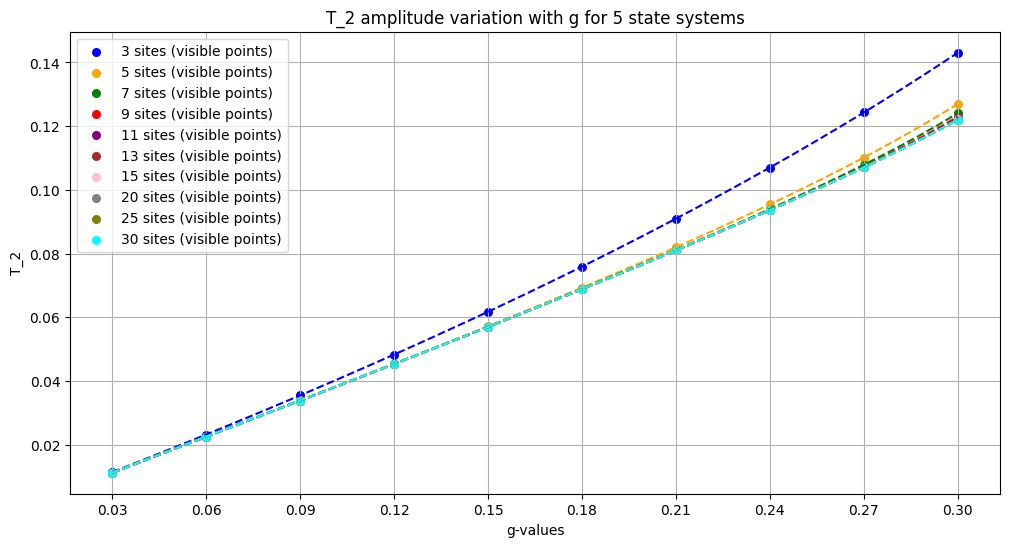

In [ ]:
t_2_3 = t_2_amplitude_matrix_5[0, :]
t_2_5 = t_2_amplitude_matrix_5[1, :]
t_2_7 = t_2_amplitude_matrix_5[2, :]
t_2_9 = t_2_amplitude_matrix_5[3, :]
t_2_11 = t_2_amplitude_matrix_5[4, :]
t_2_13 = t_2_amplitude_matrix_5[5, :]
t_2_15 = t_2_amplitude_matrix_5[6, :]
t_2_20 = t_2_amplitude_matrix_5[7, :]
t_2_25 = t_2_amplitude_matrix_5[8, :]
t_2_30 = t_2_amplitude_matrix_5[9, :]

plt.figure(figsize=(12, 6))

# Use consistent colors
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

scatter_and_fit(g_vals, t_2_3, '3 sites', colors[0])
scatter_and_fit(g_vals, t_2_5, '5 sites',  colors[1])
scatter_and_fit(g_vals, t_2_7, '7 sites',  colors[2])
scatter_and_fit(g_vals, t_2_9, '9 sites',  colors[3])
scatter_and_fit(g_vals, t_2_11, '11 sites',  colors[4])
scatter_and_fit(g_vals, t_2_13, '13 sites',  colors[5])
scatter_and_fit(g_vals, t_2_15, '15 sites',  colors[6])
scatter_and_fit(g_vals, t_2_20, '20 sites',  colors[7])
scatter_and_fit(g_vals, t_2_25, '25 sites',  colors[8])
scatter_and_fit(g_vals, t_2_30, '30 sites',  colors[9])

# Axis formatting
plt.xticks(g_vals)
plt.xlabel("g-values")
plt.ylabel("T_2")
plt.title("T_2 amplitude variation with g for 5 state systems")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
t_1_amplitude_matrix_7 = np.zeros((10, 10))
t_2_amplitude_matrix_7 = np.zeros((10, 10))

for g_index in range(10):
    for site_index in range(10):
            g = g_vals[g_index]
            site = site_vals[site_index]

            t_1, t_2 = load_one_simulation_t_amplitudes(site, 7, g, file_path_T_amplitudes)

            largest_t_2 = np.max(np.abs(t_2))
            largest_t_1 = np.max(np.abs(t_1))

            t_1_amplitude_matrix_7[site_index, g_index] = largest_t_1
            t_2_amplitude_matrix_7[site_index, g_index] = largest_t_2

/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_43369/3831408118.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_43369/3831408118.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_43369/3831408118.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_43369/3831408118.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_43369/3831408118.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_43369/3831408118.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var

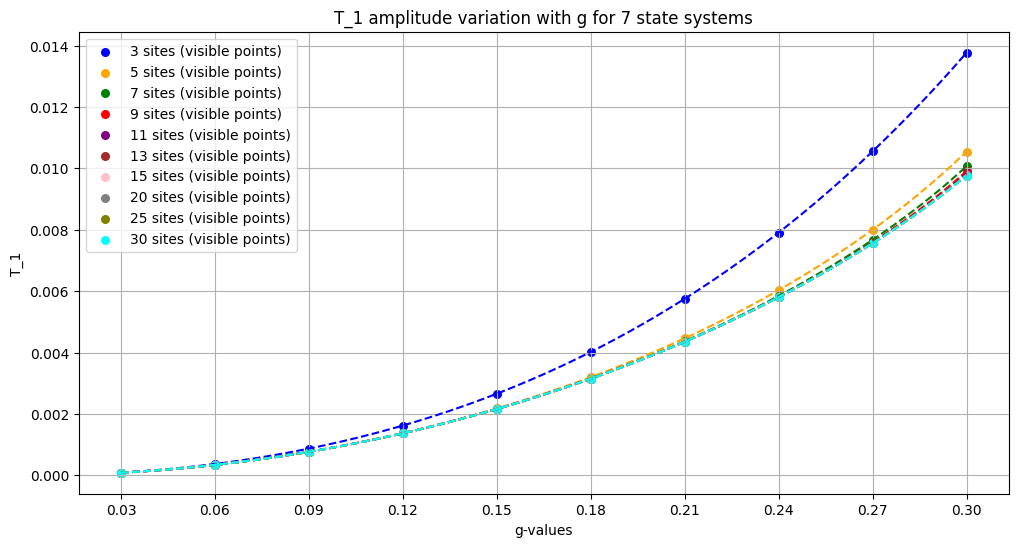

In [ ]:
t_1_3 = t_1_amplitude_matrix_7[0, :]
t_1_5 = t_1_amplitude_matrix_7[1, :]
t_1_7 = t_1_amplitude_matrix_7[2, :]
t_1_9 = t_1_amplitude_matrix_7[3, :]
t_1_11 = t_1_amplitude_matrix_7[4, :]
t_1_13 = t_1_amplitude_matrix_7[5, :]
t_1_15 = t_1_amplitude_matrix_7[6, :]
t_1_20 = t_1_amplitude_matrix_7[7, :]
t_1_25 = t_1_amplitude_matrix_7[8, :]
t_1_30 = t_1_amplitude_matrix_7[9, :]

plt.figure(figsize=(12, 6))

# Use consistent colors
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

scatter_and_fit(g_vals, t_1_3, '3 sites', colors[0])
scatter_and_fit(g_vals, t_1_5, '5 sites',  colors[1])
scatter_and_fit(g_vals, t_1_7, '7 sites',  colors[2])
scatter_and_fit(g_vals, t_1_9, '9 sites',  colors[3])
scatter_and_fit(g_vals, t_1_11, '11 sites',  colors[4])
scatter_and_fit(g_vals, t_1_13, '13 sites',  colors[5])
scatter_and_fit(g_vals, t_1_15, '15 sites',  colors[6])
scatter_and_fit(g_vals, t_1_20, '20 sites',  colors[7])
scatter_and_fit(g_vals, t_1_25, '25 sites',  colors[8])
scatter_and_fit(g_vals, t_1_30, '30 sites',  colors[9])

# Axis formatting
plt.xticks(g_vals)
plt.xlabel("g-values")
plt.ylabel("T_1")
plt.title("T_1 amplitude variation with g for 7 state systems")
plt.legend()
plt.grid(True)
plt.show()

/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_43369/3831408118.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_43369/3831408118.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_43369/3831408118.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_43369/3831408118.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_43369/3831408118.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_43369/3831408118.py:26: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(g, y, degree)
/var

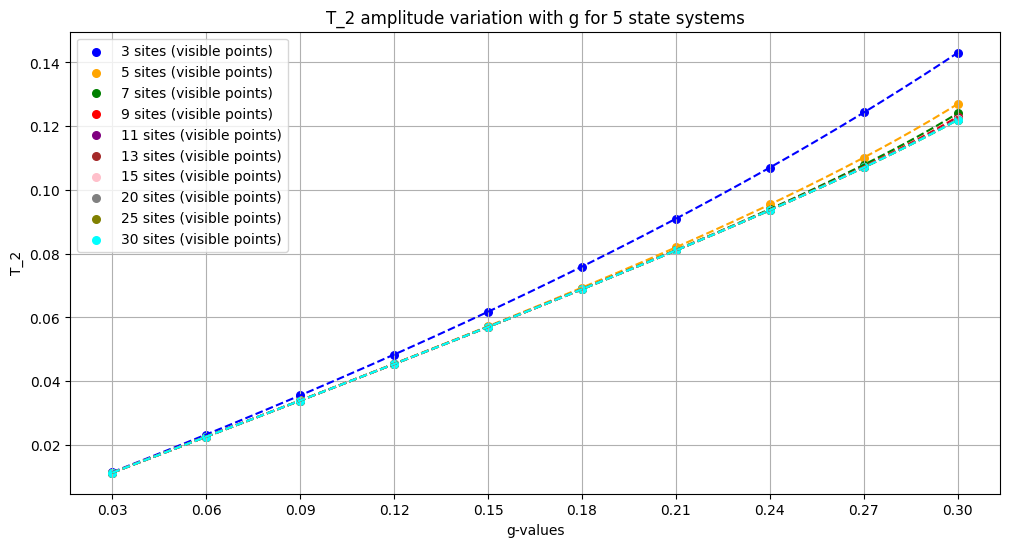

In [ ]:
t_2_3 = t_2_amplitude_matrix_7[0, :]
t_2_5 = t_2_amplitude_matrix_7[1, :]
t_2_7 = t_2_amplitude_matrix_7[2, :]
t_2_9 = t_2_amplitude_matrix_7[3, :]
t_2_11 = t_2_amplitude_matrix_7[4, :]
t_2_13 = t_2_amplitude_matrix_7[5, :]
t_2_15 = t_2_amplitude_matrix_7[6, :]
t_2_20 = t_2_amplitude_matrix_7[7, :]
t_2_25 = t_2_amplitude_matrix_7[8, :]
t_2_30 = t_2_amplitude_matrix_7[9, :]

plt.figure(figsize=(12, 6))

# Use consistent colors
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

scatter_and_fit(g_vals, t_2_3, '3 sites', colors[0])
scatter_and_fit(g_vals, t_2_5, '5 sites',  colors[1])
scatter_and_fit(g_vals, t_2_7, '7 sites',  colors[2])
scatter_and_fit(g_vals, t_2_9, '9 sites',  colors[3])
scatter_and_fit(g_vals, t_2_11, '11 sites',  colors[4])
scatter_and_fit(g_vals, t_2_13, '13 sites',  colors[5])
scatter_and_fit(g_vals, t_2_15, '15 sites',  colors[6])
scatter_and_fit(g_vals, t_2_20, '20 sites',  colors[7])
scatter_and_fit(g_vals, t_2_25, '25 sites',  colors[8])
scatter_and_fit(g_vals, t_2_30, '30 sites',  colors[9])

# Axis formatting
plt.xticks(g_vals)
plt.xlabel("g-values")
plt.ylabel("T_2")
plt.title("T_2 amplitude variation with g for 5 state systems")
plt.legend()
plt.grid(True)
plt.show()

# Graph Energy difference for large systems.

In [ ]:
log_energy_diff = np.zeros((10, 2))

for g_index in range(2):
    for site_index in range(10):
            g = g_vals[g_index]
            site = site_vals[site_index]

            energy_matrix_5 = np.load(f"{file_path_T_amplitudes}/energy_matrix_5.npy")
            energy_matrix_7 = np.load(f"{file_path_T_amplitudes}/energy_matrix_7.npy")

            log_energy_diff[site_index, g_index] = energy_matrix_7[site_index, g_index]/site

            # log_energy_diff[site_index, g_index] = np.log(energy_matrix_5[site_index, g_index]/site - energy_matrix_7[site_index, g_index]/site) / np.log()

/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_61554/4243042644.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  log_energy_diff[site_index, g_index] = energy_matrix_7[site_index, g_index]/site


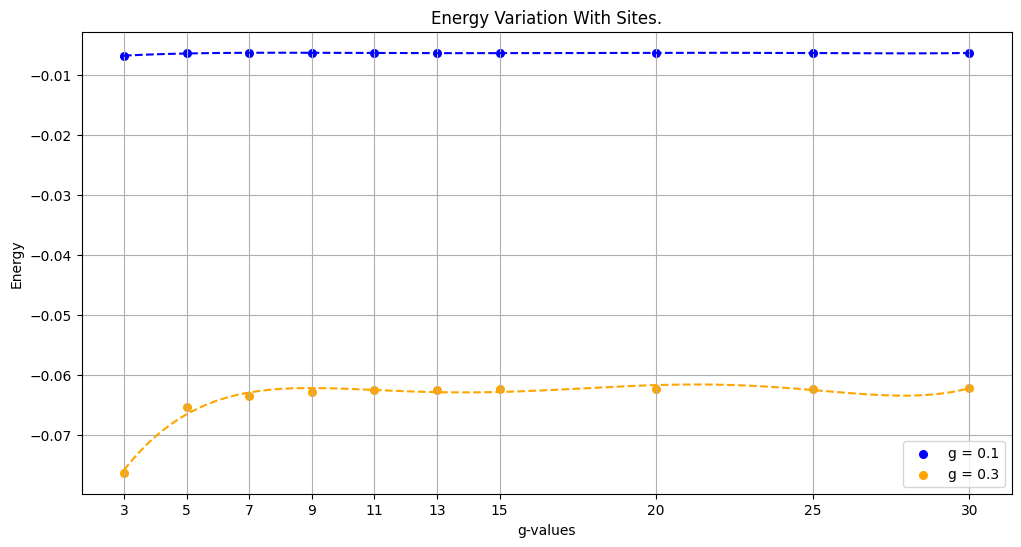

In [ ]:
t_1_3 = log_energy_diff[:, 0]
t_1_5 = log_energy_diff[:, 1]

plt.figure(figsize=(12, 6))

deg = 5

# Use consistent colors
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

scatter_and_fit(site_vals, t_1_3, 'g = 0.1', colors[0], deg)
scatter_and_fit(site_vals, t_1_5, 'g = 0.3',  colors[1], deg)

# Axis formatting
plt.xticks(site_vals)
plt.xlabel("g-values")
plt.ylabel("Energy")
plt.title("Energy Variation With Sites.")
plt.legend()
plt.grid(True)
plt.show()

## T_amplitude decay for large systems

In [ ]:
def upper_triangle_index(a, b, n):
    return (2 * n - a + 1) * a // 2 + (b - a)

In [ ]:
sites = 30
states = 7
amplitude_per_site_matrix_01 = np.zeros((30), dtype=complex)
amplitude_per_site_matrix_02 = np.zeros((30), dtype=complex)
amplitude_per_site_matrix_03 = np.zeros((30), dtype=complex)

_, t_2_1 = load_one_simulation_t_amplitudes(sites, states, 0.1, file_path_T_amplitudes)
_, t_2_2 = load_one_simulation_t_amplitudes(sites, states, 0.2, file_path_T_amplitudes)
_, t_2_3 = load_one_simulation_t_amplitudes(sites, states, 0.3, file_path_T_amplitudes)

for site in range(1, sites-1):

    amplitude_per_site_matrix_01[site] = np.log10(np.max(np.abs(t_2_1[0, site])))
    amplitude_per_site_matrix_02[site] = np.log10(np.max(np.abs(t_2_2[0, site])))
    amplitude_per_site_matrix_03[site] = np.log10(np.max(np.abs(t_2_3[0, site])))

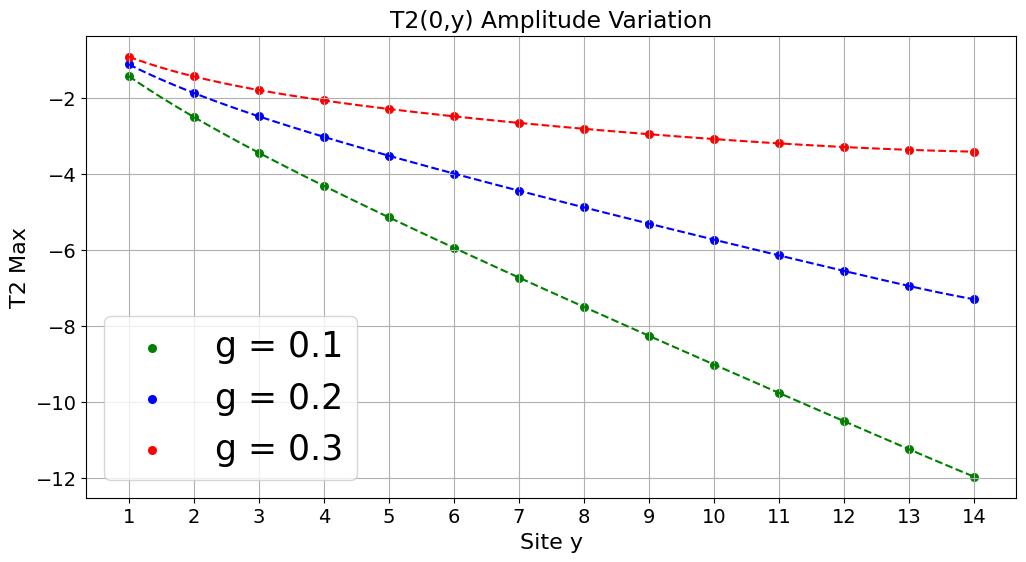

In [ ]:
x = np.arange(1, 15)

t_per_site_1 = amplitude_per_site_matrix_01[1:15]
t_per_site_2 = amplitude_per_site_matrix_02[1:15]
t_per_site_3 = amplitude_per_site_matrix_03[1:15]

plt.figure(figsize=(12, 6))

scatter_and_fit(x, t_per_site_1, "g = 0.1", color='green', degree=10)
scatter_and_fit(x, t_per_site_2, "g = 0.2", color='blue', degree=10)
scatter_and_fit(x, t_per_site_3, "g = 0.3", color='red', degree=10)

# Axis formatting
plt.xticks(x)
plt.xlabel("Site y")
plt.ylabel("T2 Max")
plt.title(f"T2(0,y) Amplitude Variation")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def convert_i_to_site_state(states: int, sites: int, looking_for_site: int) -> np.ndarray:

    for x in range(sites):

        n_lambda = states**(x)
        n_mu = states**(sites - x - 1)
        # Loop over the local states at the chosen site
        for p in range(states):

            # Sum over all other sites (Lambda and mu represent other sites)
            for Lambda in range(int(n_lambda)):
                for mu in range(int(n_mu)):

                    # Full indices in the Hilbert space
                    i = mu + p * n_mu + Lambda * states * n_mu

                    if i == looking_for_site:
                        return x, p

In [ ]:
si5_st5_NO = []
g_array = []

for g_index in range(10, 51, 10):

    states = 11
    sites = 3
    g = g_index / 10
    g_array.append(g)
    print(f"g-val: {g}")

    H = hamiltonian(states, sites, g, spar=True)

    eig_val, eig_vec = eigsh(H[0], k=(100), which='SA')

    index_array = np.argsort(eig_val)

    D_sum = np.zeros((states, states), dtype=complex)
    D_avg = np.zeros((states, states), dtype=complex)

    for i in range(6):
        D_1 = density_matrix_1(states, sites, eig_vec[:, index_array[i]], convert_i_to_site_state(states, sites, index_array[i])[0])
        D_sum += D_1

    D_avg = D_sum / 6

    print(np.trace(D_avg))

    eig_val_D, eig_vec_D = np.linalg.eig(D_avg)

    index_array_D = np.argsort(-eig_val_D)

    states = 5
    sites = 7

    matrix_p_to_natural_orbital = eig_vec_D[:, index_array_D[:states]]
    matrix_p_to_natural_orbital_sparse = csr_matrix(matrix_p_to_natural_orbital[:, index_array_D[:states]])

    K = H[1]
    V = H[2]

    print(V.shape)
    print(matrix_p_to_natural_orbital_sparse.shape)
    print(kron(matrix_p_to_natural_orbital_sparse.T.conj(), matrix_p_to_natural_orbital_sparse.T.conj()).shape)

    V = V.reshape(11**2,11**2)
    V_mu = kron(matrix_p_to_natural_orbital_sparse.T.conj(), matrix_p_to_natural_orbital_sparse.T.conj()) @ V @ kron(matrix_p_to_natural_orbital_sparse, matrix_p_to_natural_orbital_sparse)
    K_mu = matrix_p_to_natural_orbital_sparse.T.conj() @ K @ matrix_p_to_natural_orbital_sparse

    print("Check 1")

    H_new = hamiltonian(states, sites, g, 0, K_mu, V_mu, True, True)

    print("Check 2")

    eigvals_7_5, eigvecs_7_5 = eigsh(H_new[0], k=6, which='SA')

    si5_st5_NO.append(eigvals_7_5)

g-val: 1.0
Done generating hamiltonian.
(1.0000000000000266+7.454379725891731e-19j)
(121, 121)
(11, 5)
(25, 121)
Check 1
Done generating hamiltonian.
Check 2
g-val: 2.0
Done generating hamiltonian.
(1.0000000000000333-1.4882244068523319e-18j)
(121, 121)
(11, 5)
(25, 121)
Check 1
Done generating hamiltonian.
Check 2
g-val: 3.0
Done generating hamiltonian.
(1.0000000000000524+1.3059263671481873e-18j)
(121, 121)
(11, 5)
(25, 121)
Check 1
Done generating hamiltonian.
Check 2
g-val: 4.0
Done generating hamiltonian.
(1.0000000000000346+1.6713098001401297e-18j)
(121, 121)
(11, 5)
(25, 121)
Check 1
Done generating hamiltonian.
Check 2
g-val: 5.0
Done generating hamiltonian.
(1.0000000000000335+1.7729388686708647e-18j)
(121, 121)
(11, 5)
(25, 121)
Check 1
Done generating hamiltonian.
Check 2


In [ ]:
si5_st5_NO

[array([-5.208475048782, -5.207565609476, -3.627780928558, -3.627780928558, -3.618877080108, -3.618877080108]),
 array([-15.115684655344, -15.11568311623 , -12.604717913801, -12.604742360539, -12.6047179138  , -12.604742360539]),
 array([-25.99125801621 , -25.991258001878, -22.780622761104, -22.780622984847, -22.780622761104, -22.780622984847]),
 array([-37.364054520632, -37.364054521025, -33.567739322771, -33.567739317173, -33.567739317172, -33.56773932277 ]),
 array([-49.053310495245, -49.053310495271, -44.740966332509, -44.740966332845, -44.740966332845, -44.740966332509])]

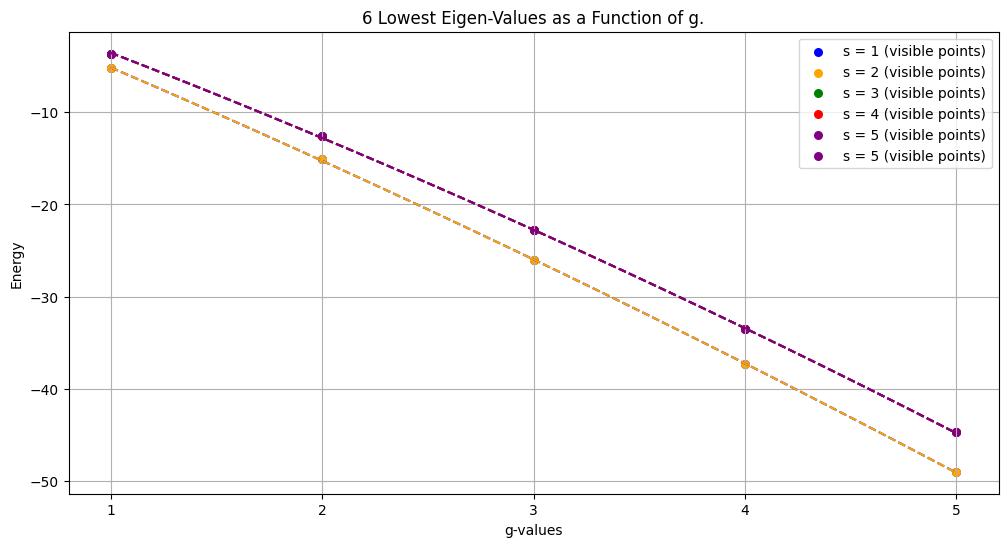

In [ ]:
x = np.arange(1, 6)
si5_st5_NO = np.array(si5_st5_NO)

plt.figure(figsize=(12, 6))

degree=2
colors = ['blue', 'orange', 'green', 'red', 'purple']

scatter_and_fit(x, si5_st5_NO[:,0], "s = 1", colors[0], degree)
scatter_and_fit(x, si5_st5_NO[:,1], "s = 2", colors[1], degree)
scatter_and_fit(x, si5_st5_NO[:,2], "s = 3", colors[2], degree)
scatter_and_fit(x, si5_st5_NO[:,3], "s = 4", colors[3], degree)
scatter_and_fit(x, si5_st5_NO[:,4], "s = 5", colors[4], degree)
scatter_and_fit(x, si5_st5_NO[:,5], "s = 5", colors[4], degree)

# Axis formatting
plt.xticks(x)
plt.xlabel("g-values")
plt.ylabel("Energy")
plt.title(f"6 Lowest Eigen-Values as a Function of g.")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
si5_st5_NO[2]

array([0.393009170481-0.j, 0.374493704444+0.j, 0.131013206141+0.j, 0.09794015394 -0.j, 0.002392475733+0.j, 0.000946631329+0.j, 0.000175623228+0.j, 0.000023516227-0.j, 0.000005179185+0.j, 0.000000241746-0.j, 0.000000097547+0.j])

In [ ]:
si5_st5_NO = []
g_array = []
states = 5
sites = 5


for g_index in range(1, 51):
    g = g_index / 10
    g_array.append(g)

    eig_val, eig_vec, __ = load_one_simulation_NO(sites, states, g, file_path_ED)
    index_array = np.argsort(eig_val)

    si5_st5_NO.append(eig_val[index_array[0:6]])

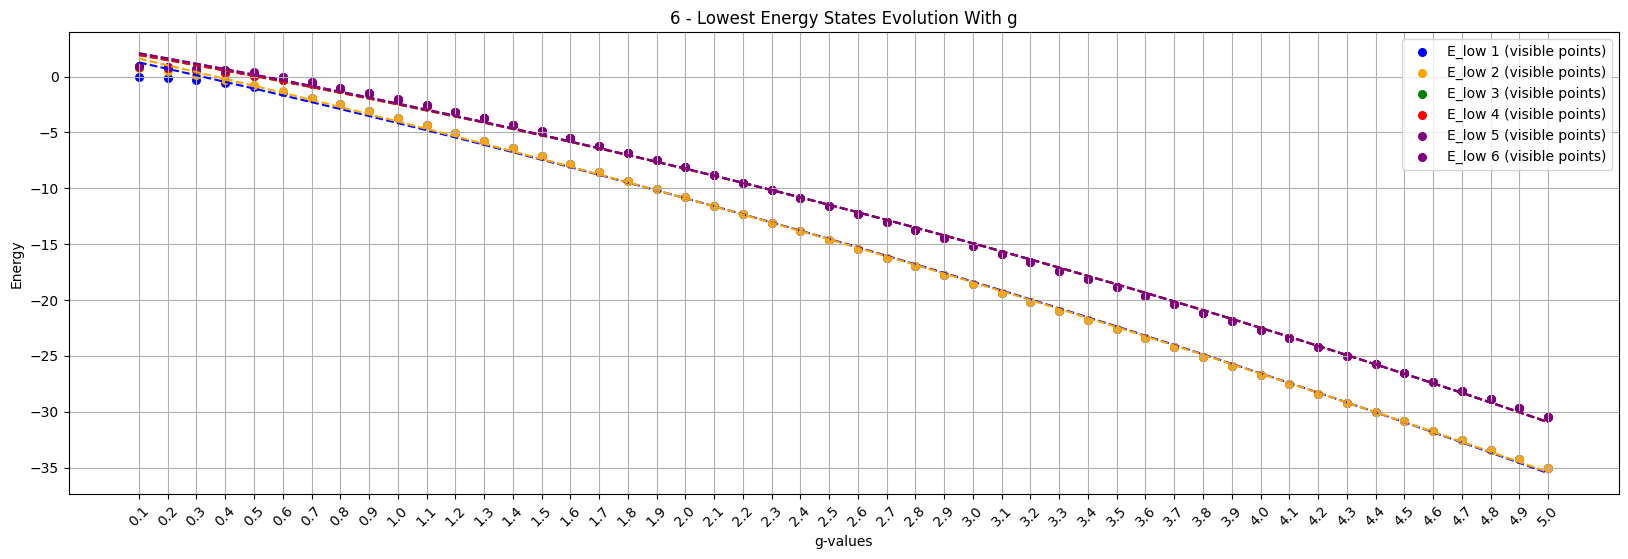

In [ ]:
x = np.array(g_array)
si5_st5_NO = np.array(si5_st5_NO)

plt.figure(figsize=(20, 6))

degree=2
colors = ['blue', 'orange', 'green', 'red', 'purple']

scatter_and_fit(x, si5_st5_NO[:,0], "E_low 1", colors[0], degree)
scatter_and_fit(x, si5_st5_NO[:,1], "E_low 2", colors[1], degree)
scatter_and_fit(x, si5_st5_NO[:,2], "E_low 3", colors[2], degree)
scatter_and_fit(x, si5_st5_NO[:,3], "E_low 4", colors[3], degree)
scatter_and_fit(x, si5_st5_NO[:,4], "E_low 5", colors[4], degree)
scatter_and_fit(x, si5_st5_NO[:,5], "E_low 6", colors[4], degree)

# Axis formatting
plt.xticks(x, rotation=45)
plt.xlabel("g-values")
plt.ylabel("Energy")
plt.title(f"6 - Lowest Energy States Evolution With g")
plt.legend()
plt.grid(True)
plt.show()